# Insurance Claim Prediction - Enhanced Pipeline with Cross-Validation

Complete ML pipeline with:
- **Cross-Validation** instead of single train/validation split
- Comprehensive EDA visualizations including feature-target relationships
- **Per-model oversampling/undersampling analysis**
- Intelligent application of SMOTE, ADASYN, undersampling, or hybrid methods
- **Best model selection based on actual performance scores (F1, ROC-AUC, Precision, Recall)**
- Detailed metrics comparison for all models
- Final test set evaluation with diagnostic visualizations

In [254]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (classification_report, confusion_matrix, f1_score, 
                             roc_auc_score, roc_curve, auc, accuracy_score, 
                             precision_score, recall_score)
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek, SMOTEENN
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully


## 1. Load and Explore Raw Data

In [255]:
train_raw = pd.read_csv("train_Insurance.csv")
test_raw = pd.read_csv("test_Insurance.csv")

print(f"Train shape: {train_raw.shape}")
print(f"Test shape: {test_raw.shape}")
print(f"\nTrain columns: {list(train_raw.columns)}")
print(f"\nFirst 5 rows:")
print(train_raw.head())
print(f"\nData types:")
print(train_raw.dtypes)
print(f"\nBasic statistics:")
print(train_raw.describe())

Train shape: (5012, 13)
Test shape: (2147, 13)

Train columns: ['Customer Id', 'YearOfObservation', 'Insured_Period', 'Residential', 'Building_Painted', 'Building_Fenced', 'Garden', 'Settlement', 'Building Dimension', 'Building_Type', 'NumberOfWindows', 'Geo_Code', 'Claim']

First 5 rows:
  Customer Id  YearOfObservation  Insured_Period  Residential  \
0      H13501               2012             1.0            1   
1      H14962               2012             1.0            0   
2      H17755               2013             1.0            1   
3      H13369               2016             0.5            0   
4      H12988               2012             1.0            0   

  Building_Painted Building_Fenced Garden Settlement  Building Dimension  \
0                N               V      V          U              1240.0   
1                N               V      V          U               900.0   
2                V               N      O          R              4984.0   
3              

### Visualize Missing Values

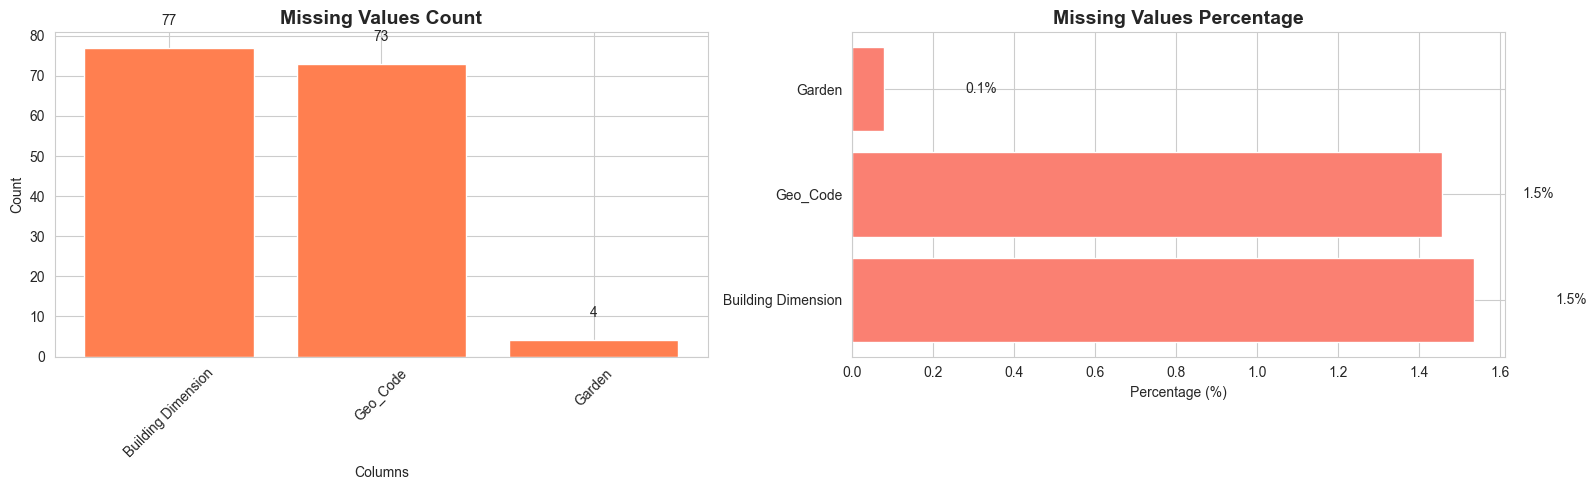

In [256]:
missing = train_raw.isna().sum()
missing = missing[missing > 0].sort_values(ascending=False)

if len(missing) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    axes[0].bar(missing.index, missing.values, color='coral')
    axes[0].set_title('Missing Values Count', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Count')
    axes[0].set_xlabel('Columns')
    axes[0].tick_params(axis='x', rotation=45)
    for i, v in enumerate(missing.values):
        axes[0].text(i, v + 5, str(v), ha='center', va='bottom')
    
    missing_pct = (missing / len(train_raw)) * 100
    axes[1].barh(missing_pct.index, missing_pct.values, color='salmon')
    axes[1].set_title('Missing Values Percentage', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Percentage (%)')
    for i, v in enumerate(missing_pct.values):
        axes[1].text(v + 0.2, i, f'{v:.1f}%', va='center')
    
    plt.tight_layout()
    plt.show()
else:
    print("No missing values found")

### Target Variable Distribution

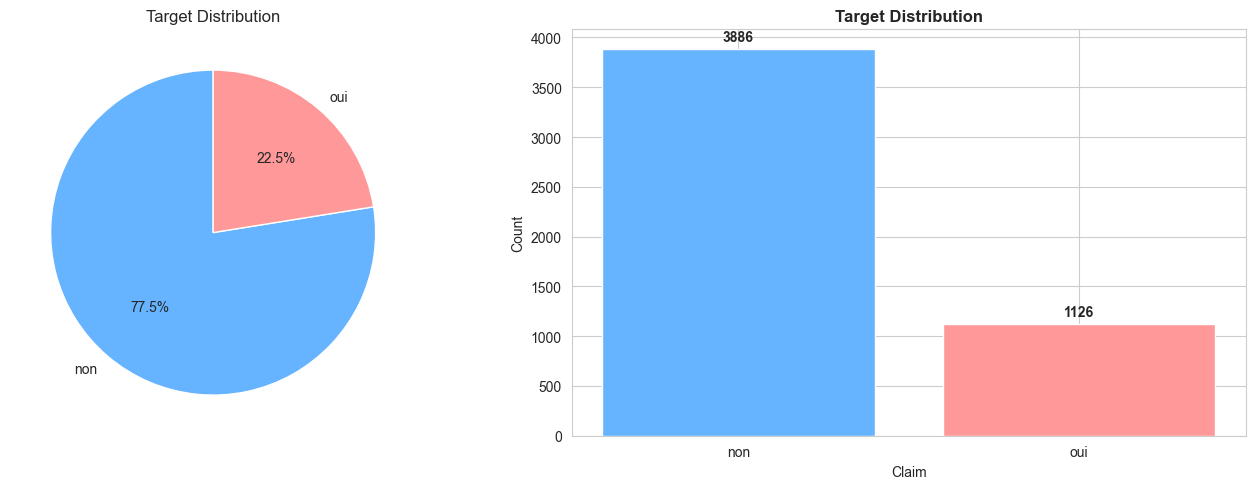


Class distribution:
Claim
non    3886
oui    1126
Name: count, dtype: int64

Class proportions:
Claim
non    0.775339
oui    0.224661
Name: proportion, dtype: float64


In [257]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

train_raw['Claim'].value_counts().plot.pie(
    autopct='%1.1f%%',
    ax=axes[0],
    ylabel='',
    colors=['#66b3ff', '#ff9999'],
    title='Target Distribution',
    startangle=90
)

claim_counts = train_raw['Claim'].value_counts()
axes[1].bar(claim_counts.index, claim_counts.values, color=['#66b3ff', '#ff9999'])
axes[1].set_title('Target Distribution', fontweight='bold')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Claim')
for i, v in enumerate(claim_counts.values):
    axes[1].text(i, v + 50, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nClass distribution:")
print(train_raw['Claim'].value_counts())
print(f"\nClass proportions:")
print(train_raw['Claim'].value_counts(normalize=True))

### Visualize Categorical Features

Categorical columns: ['Building_Painted', 'Building_Fenced', 'Garden', 'Settlement', 'Building_Type', 'NumberOfWindows', 'Geo_Code']


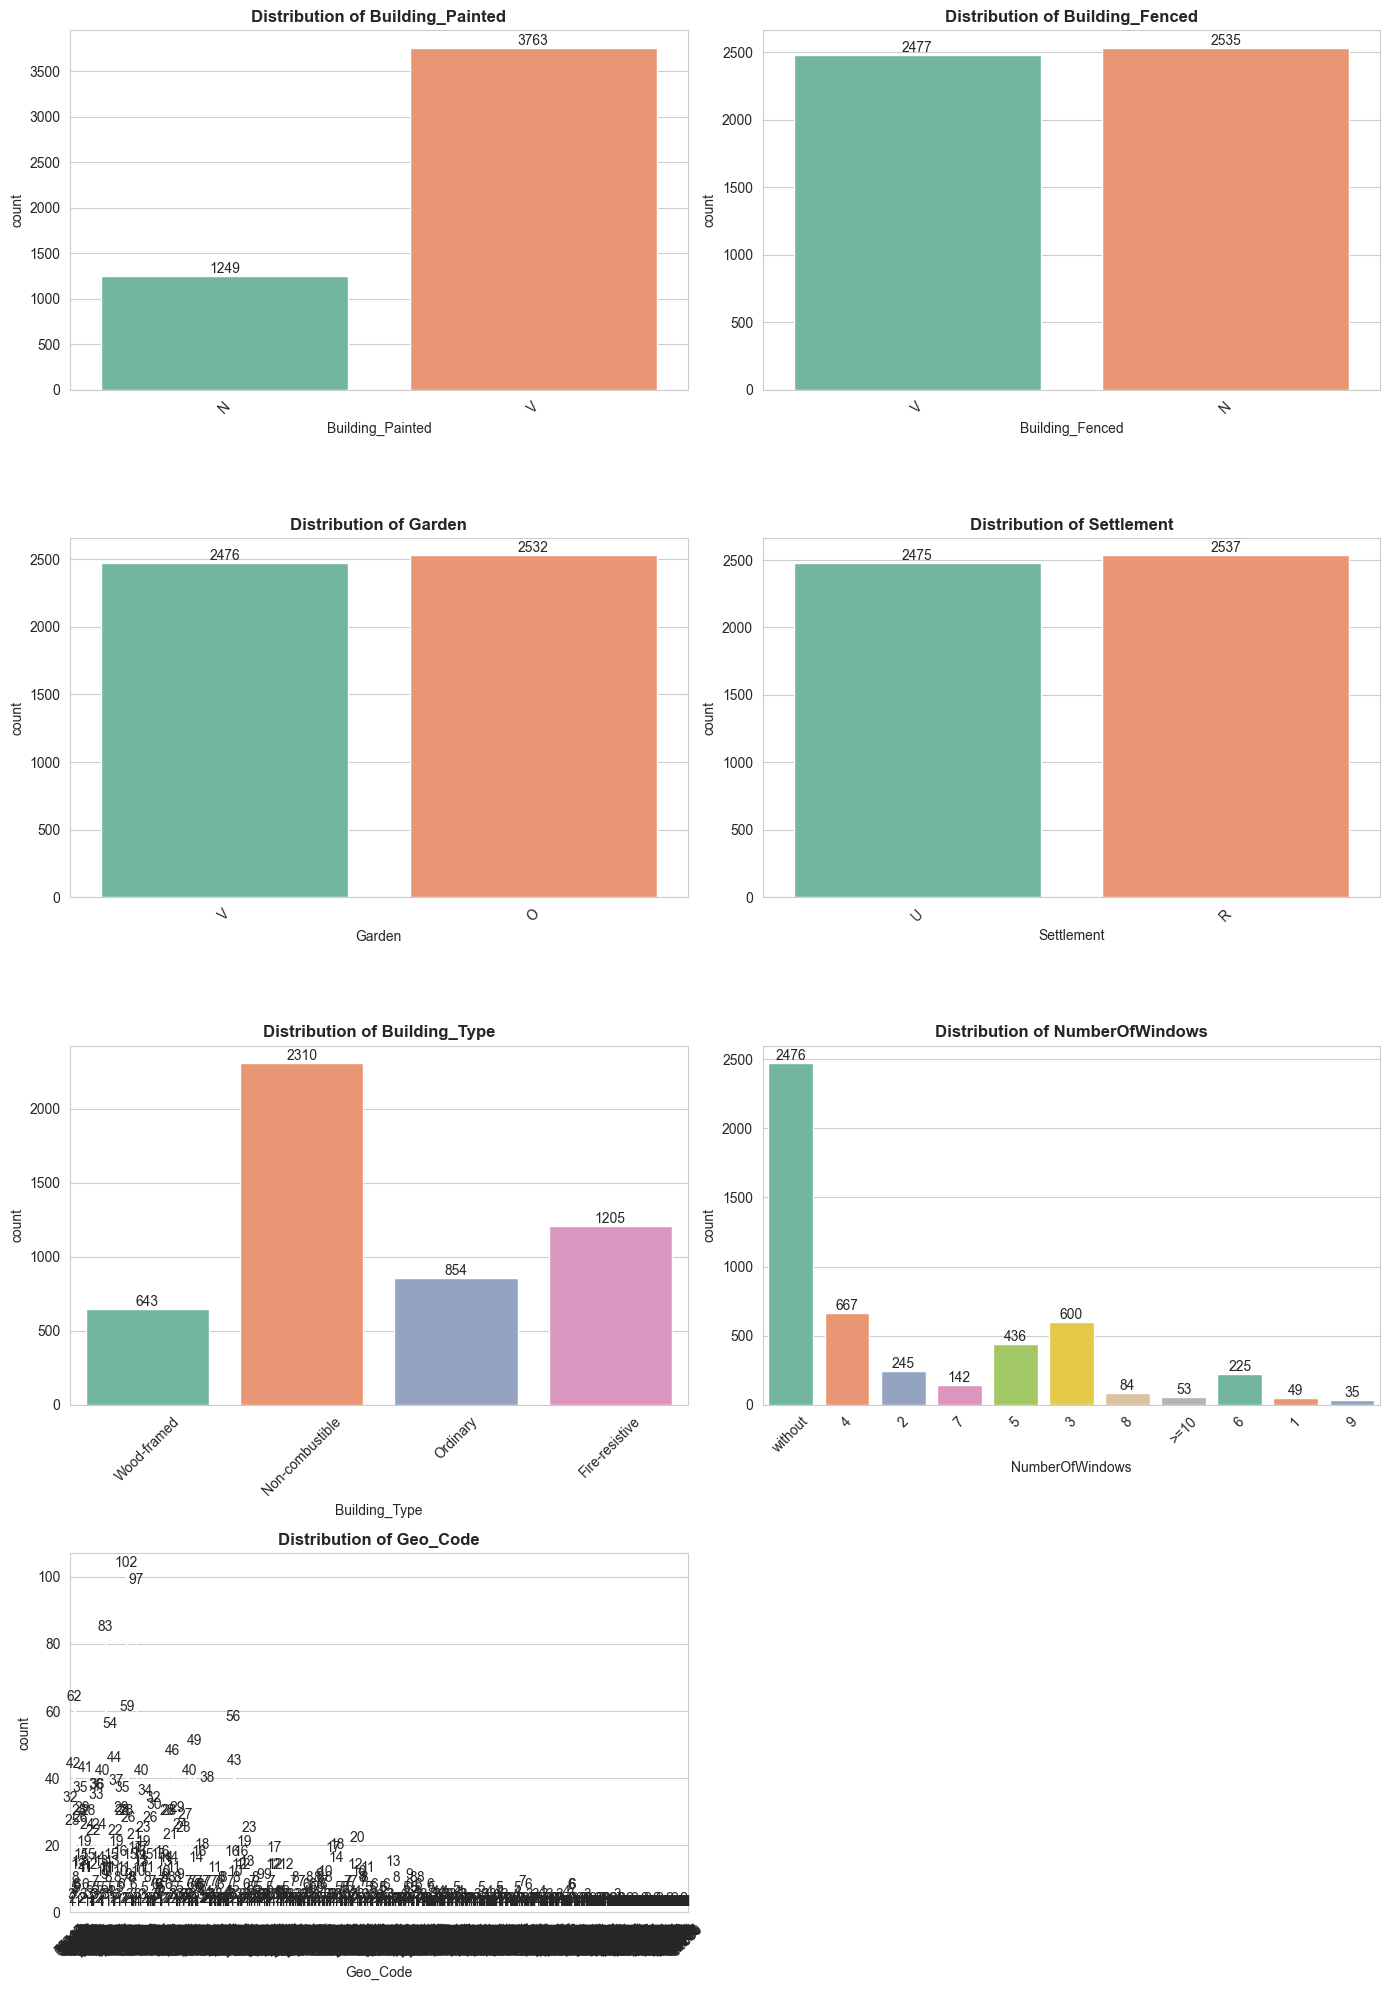

In [258]:
cat_cols = [col for col in train_raw.select_dtypes(include=["object", "category"]).columns
            if col not in ["Claim", "Customer Id"]]

print("Categorical columns:", cat_cols)

n_cols = 2
n_rows = math.ceil(len(cat_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(x=col, data=train_raw, ax=axes[i], palette='Set2')
    axes[i].set_title(f"Distribution of {col}", fontweight='bold')
    axes[i].tick_params(axis='x', rotation=45)
    
    for container in axes[i].containers:
        axes[i].bar_label(container)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Visualize Numerical Features

Numerical columns: ['YearOfObservation', 'Insured_Period', 'Residential', 'Building Dimension']


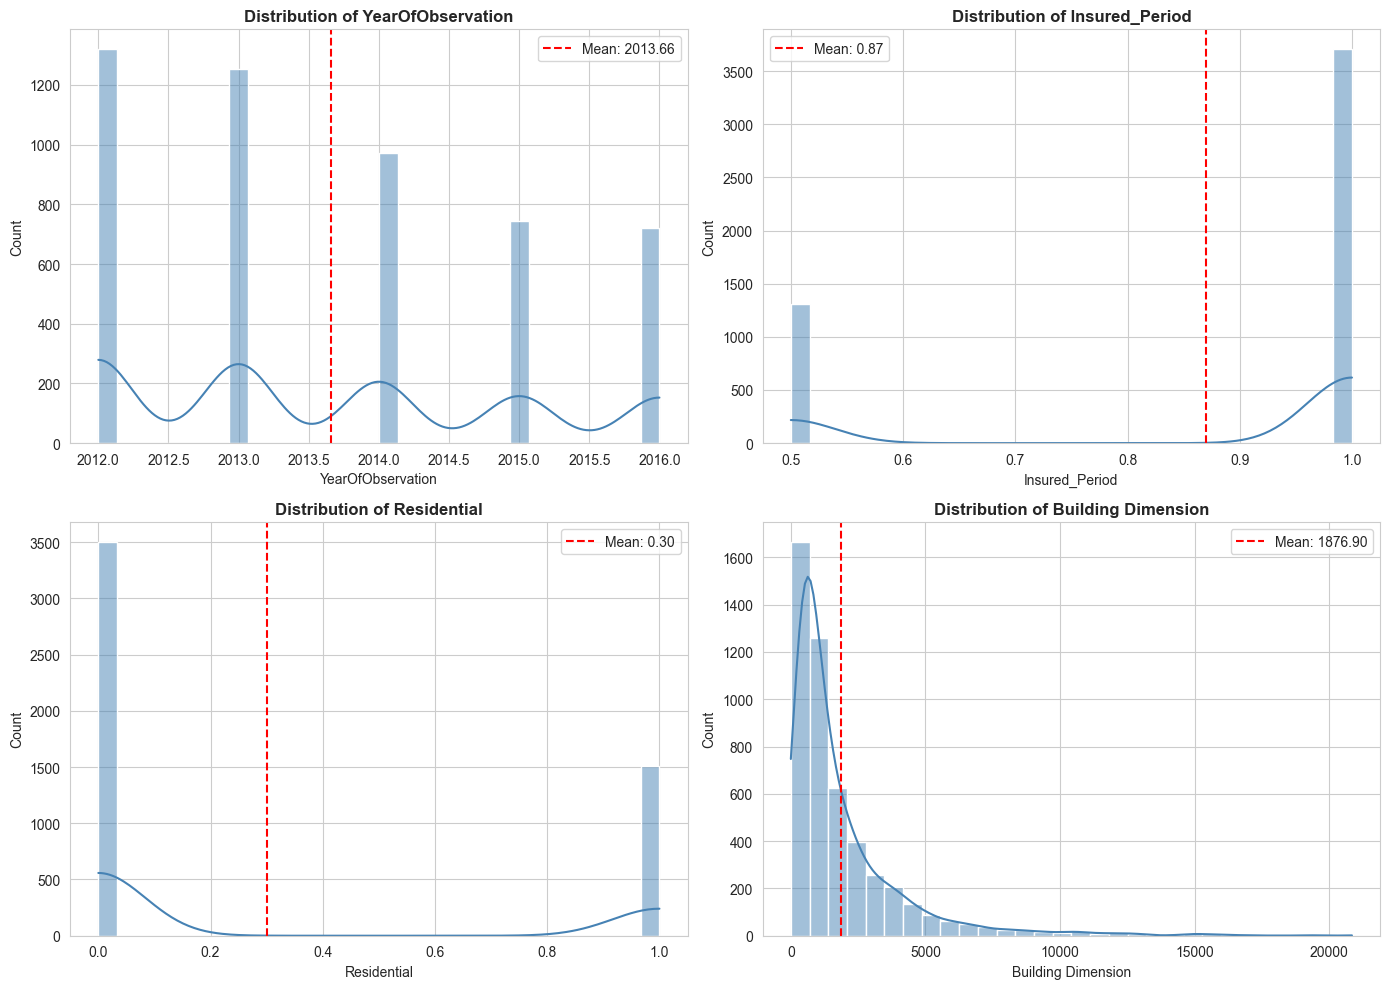

In [259]:
num_cols = train_raw.select_dtypes(include=["int64", "float64"]).columns.tolist()
num_cols = [c for c in num_cols if c not in ["Claim", "Customer Id"]]

print(f"Numerical columns: {num_cols}")

n_cols = 2
n_rows = math.ceil(len(num_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(train_raw[col].dropna(), kde=True, ax=axes[i], color='steelblue', bins=30)
    axes[i].set_title(f"Distribution of {col}", fontweight='bold')
    axes[i].set_xlabel(col)
    mean_val = train_raw[col].mean()
    axes[i].axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
    axes[i].legend()

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 2. Data Cleaning Pipeline (Testing and Training Data)

In [260]:
# Step 1: Remove Customer ID
train_raw.drop(labels=['Customer Id'], axis=1, inplace=True)
test_raw.drop(labels=['Customer Id'], axis=1, inplace=True)

# Step 2: Clean NumberOfWindows
train_raw['NumberOfWindows'] = train_raw['NumberOfWindows'].replace({'without': 0, '>=10': 10})
train_raw['NumberOfWindows'] = train_raw['NumberOfWindows'].astype(int)
test_raw['NumberOfWindows'] = test_raw['NumberOfWindows'].replace({'without': 0, '>=10': 10})
test_raw['NumberOfWindows'] = test_raw['NumberOfWindows'].astype(int)

# Step 3: Remove Duplicates and Conflicts
n_exact = train_raw.duplicated().sum()
n_same_features = train_raw.duplicated(subset=[c for c in train_raw.columns if c != 'Claim']).sum()

print(f"Exact duplicates: {n_exact}")
print(f"Duplicates with same features: {n_same_features}")

if n_same_features > 0:
    features = [c for c in train_raw.columns if c != "Claim"]
    dups = train_raw[train_raw.duplicated(subset=features, keep=False)]
    conflicts = dups.groupby(features)['Claim'].nunique()
    n_conflicts = (conflicts > 1).sum()
    print(f"Conflicting records: {n_conflicts}")
    
    if n_conflicts > 0:
        conflicting_groups = conflicts[conflicts > 1].reset_index()
        before = len(train_raw)
        train_raw = train_raw.merge(conflicting_groups[features], on=features, how='left', indicator=True)
        train_raw = train_raw[train_raw['_merge'] == 'left_only'].drop(columns=['_merge'])
        after = len(train_raw)
        print(f"Removed {before - after} conflicting records")

train_raw.drop_duplicates(inplace=True)
print(f"Train shape after cleaning: {train_raw.shape}")

Exact duplicates: 42
Duplicates with same features: 55
Conflicting records: 4
Removed 9 conflicting records
Train shape after cleaning: (4962, 12)


In [261]:
# Step 4: Handle Missing Values
print("Missing values in train:")
print(train_raw.isna().sum())

mf_imputer = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
train_raw[["Garden"]] = mf_imputer.fit_transform(train_raw[["Garden"]])

median_imputer = SimpleImputer(strategy="median")
train_raw[["Building Dimension"]] = median_imputer.fit_transform(train_raw[["Building Dimension"]])

# Step 5: Fill Missing Geo_Code
mode_geo_train = (
    train_raw[train_raw["Geo_Code"].notna()]
    .groupby(["Settlement", "Residential"])["Geo_Code"]
    .agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0])
    .reset_index()
    .rename(columns={"Geo_Code": "Geo_Code_mode"})
)

train_raw = train_raw.merge(mode_geo_train, on=["Settlement", "Residential"], how="left")
train_raw["Geo_Code"] = train_raw["Geo_Code"].fillna(train_raw["Geo_Code_mode"])
train_raw = train_raw.drop(columns=["Geo_Code_mode"])

# Step 6: Clean Geo_Code (remove alphanumeric)
mask_numeric = train_raw["Geo_Code"].astype(str).str.isnumeric()
train_raw = train_raw[mask_numeric].copy()
train_raw["Geo_Code"] = train_raw["Geo_Code"].astype(int)

print(f"\nTrain shape after Geo_Code cleaning: {train_raw.shape}")
print(f"Missing values after imputation:\n{train_raw.isna().sum()}")

Missing values in train:
YearOfObservation      0
Insured_Period         0
Residential            0
Building_Painted       0
Building_Fenced        0
Garden                 4
Settlement             0
Building Dimension    45
Building_Type          0
NumberOfWindows        0
Geo_Code              41
Claim                  0
dtype: int64

Train shape after Geo_Code cleaning: (4924, 12)
Missing values after imputation:
YearOfObservation     0
Insured_Period        0
Residential           0
Building_Painted      0
Building_Fenced       0
Garden                0
Settlement            0
Building Dimension    0
Building_Type         0
NumberOfWindows       0
Geo_Code              0
Claim                 0
dtype: int64


Outliers found: 391


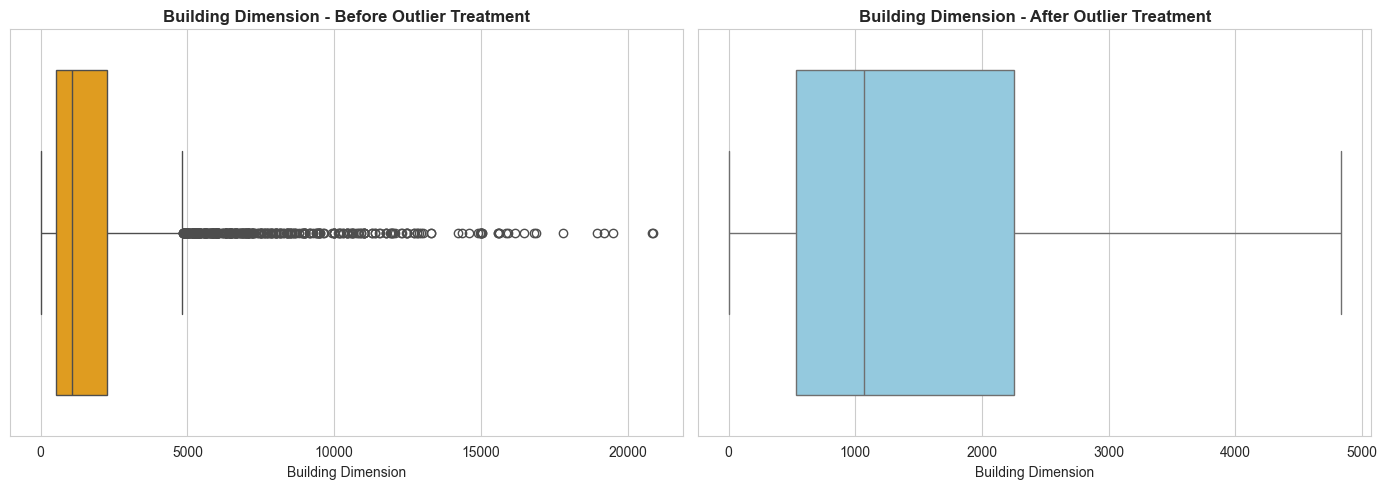

In [262]:
# Step 7: Handle Outliers in Building Dimension
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(x=train_raw['Building Dimension'], ax=axes[0], color='orange')
axes[0].set_title('Building Dimension - Before Outlier Treatment', fontweight='bold')

Q1 = train_raw['Building Dimension'].quantile(0.25)
Q3 = train_raw['Building Dimension'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers_before = (train_raw['Building Dimension'] < lower) | (train_raw['Building Dimension'] > upper)
print(f"Outliers found: {outliers_before.sum()}")

train_raw['Building Dimension'] = train_raw['Building Dimension'].clip(lower, upper)

sns.boxplot(x=train_raw['Building Dimension'], ax=axes[1], color='skyblue')
axes[1].set_title('Building Dimension - After Outlier Treatment', fontweight='bold')

plt.tight_layout()
plt.show()

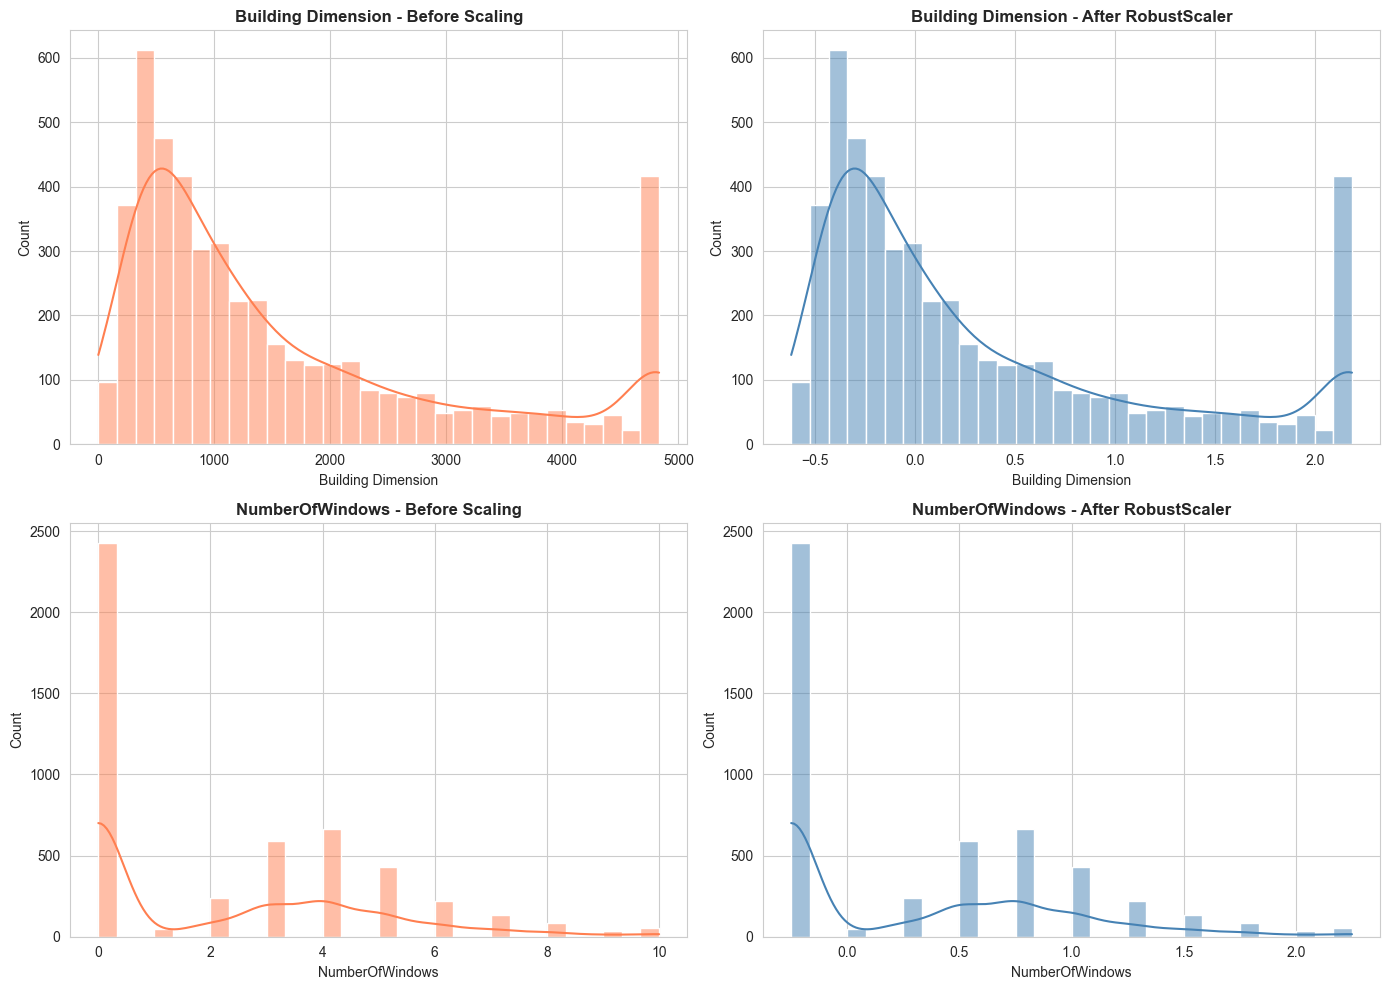

✓ RobustScaler fitted and applied


In [263]:
# Step 8: Scale Numerical Features
cols_to_scale = ['Building Dimension', 'NumberOfWindows']
scaler = RobustScaler()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for i, col in enumerate(cols_to_scale):
    sns.histplot(train_raw[col], kde=True, ax=axes[i, 0], color='coral', bins=30)
    axes[i, 0].set_title(f"{col} - Before Scaling", fontweight='bold')

train_raw[cols_to_scale] = scaler.fit_transform(train_raw[cols_to_scale])

for i, col in enumerate(cols_to_scale):
    sns.histplot(train_raw[col], kde=True, ax=axes[i, 1], color='steelblue', bins=30)
    axes[i, 1].set_title(f"{col} - After RobustScaler", fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ RobustScaler fitted and applied")

In [264]:
# Step 9: Encode Categorical Variables
train_transformed = train_raw.copy()

train_transformed["Building_Painted"] = train_transformed["Building_Painted"].map({'N': 1, 'V': 0}).astype('int32')
train_transformed["Building_Fenced"] = train_transformed["Building_Fenced"].map({'N': 1, 'V': 0}).astype('int32')
train_transformed["Garden"] = train_transformed["Garden"].map({'V': 1, 'O': 0}).astype('int32')

train_transformed = pd.get_dummies(train_transformed, columns=["Settlement", "Building_Type"], drop_first=True, dtype='int32')

le_claim = LabelEncoder()
train_transformed["Claim"] = le_claim.fit_transform(train_transformed["Claim"])

cols = [c for c in train_transformed.columns if c != "Claim"] + ["Claim"]
train_transformed = train_transformed[cols]

print("✓ Train data encoded")
print(f"Train shape: {train_transformed.shape}")

✓ Train data encoded
Train shape: (4924, 14)


### Feature-Target Relationship Analysis

FEATURE-TARGET RELATIONSHIP ANALYSIS


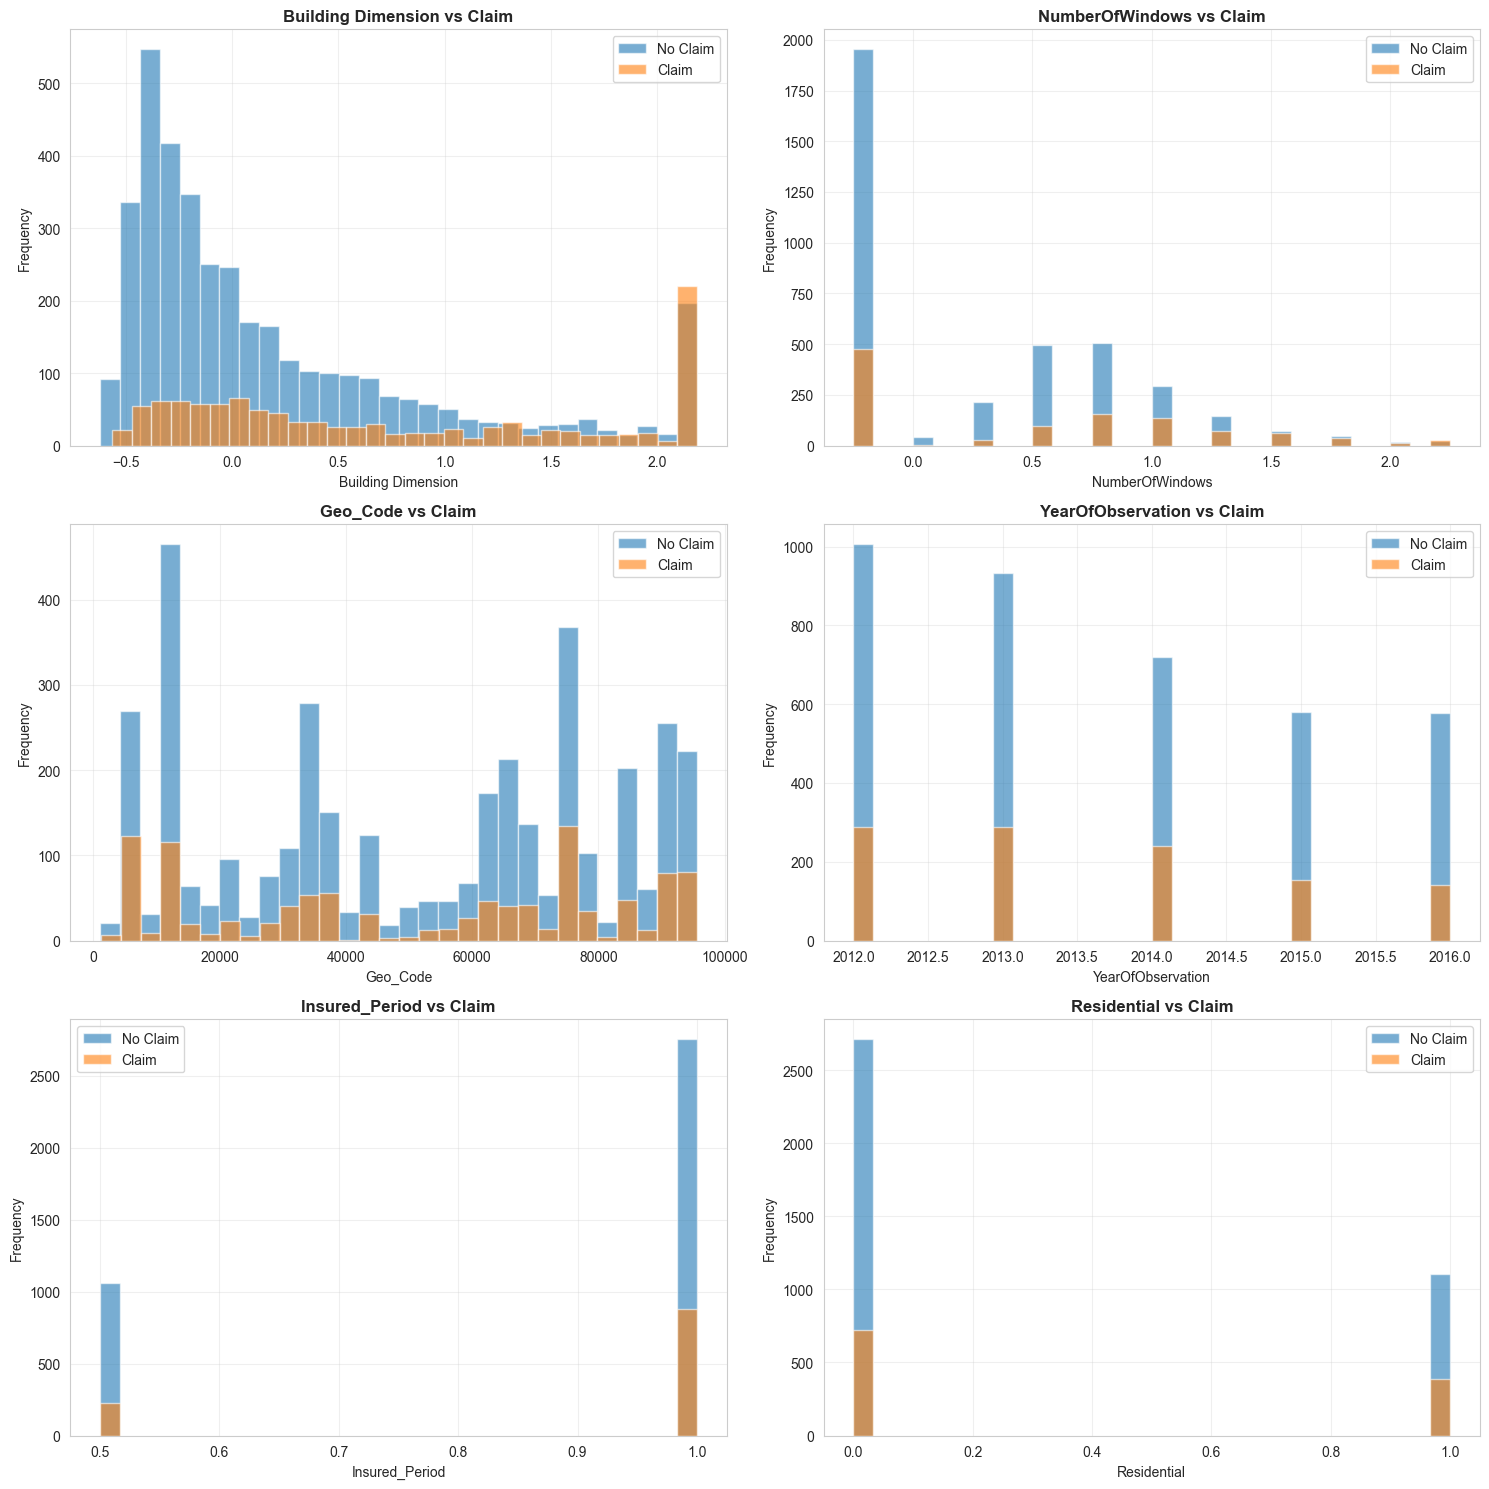

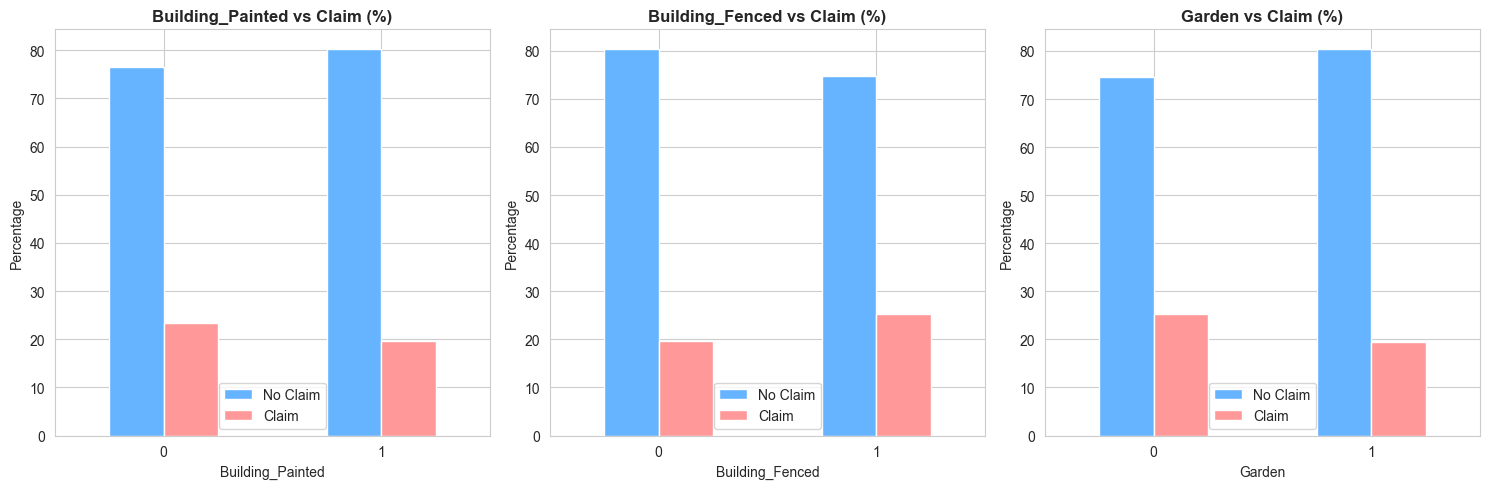

In [265]:
print("="*80)
print("FEATURE-TARGET RELATIONSHIP ANALYSIS")
print("="*80)

# Numerical features vs Target
numerical_features = ['Building Dimension', 'NumberOfWindows', 'Geo_Code', 
                     'YearOfObservation', 'Insured_Period', 'Residential']

existing_num_features = [f for f in numerical_features if f in train_transformed.columns]

if len(existing_num_features) > 0:
    n_cols = 2
    n_rows = math.ceil(len(existing_num_features) / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for i, feature in enumerate(existing_num_features):
        for claim_val in [0, 1]:
            data = train_transformed[train_transformed['Claim'] == claim_val][feature]
            label = 'No Claim' if claim_val == 0 else 'Claim'
            axes[i].hist(data, alpha=0.6, label=label, bins=30)
        
        axes[i].set_title(f'{feature} vs Claim', fontweight='bold')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frequency')
        axes[i].legend()
        axes[i].grid(alpha=0.3)
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

# Categorical features vs Target
categorical_encoded = ['Building_Painted', 'Building_Fenced', 'Garden']
existing_cat_features = [f for f in categorical_encoded if f in train_transformed.columns]

if len(existing_cat_features) > 0:
    n_cols = 3
    n_rows = math.ceil(len(existing_cat_features) / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    if n_rows == 1:
        axes = np.array([axes]) if n_cols == 1 else axes
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
    
    for i, feature in enumerate(existing_cat_features):
        crosstab = pd.crosstab(train_transformed[feature], train_transformed['Claim'], normalize='index') * 100
        crosstab.plot(kind='bar', ax=axes[i], color=['#66b3ff', '#ff9999'])
        axes[i].set_title(f'{feature} vs Claim (%)', fontweight='bold')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Percentage')
        axes[i].legend(['No Claim', 'Claim'])
        axes[i].tick_params(axis='x', rotation=0)
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

### Correlation Analysis

Top 5 Correlation with Claim:
                              Claim
Claim                      1.000000
Building Dimension         0.295465
NumberOfWindows            0.153133
Building_Type_Wood-framed  0.110515
Insured_Period             0.070592

Top 5 Mutual Information with Claim:
                           Mutual_Info
Building Dimension            0.049144
Geo_Code                      0.017906
Garden                        0.013126
Building_Type_Wood-framed     0.009358
NumberOfWindows               0.008322


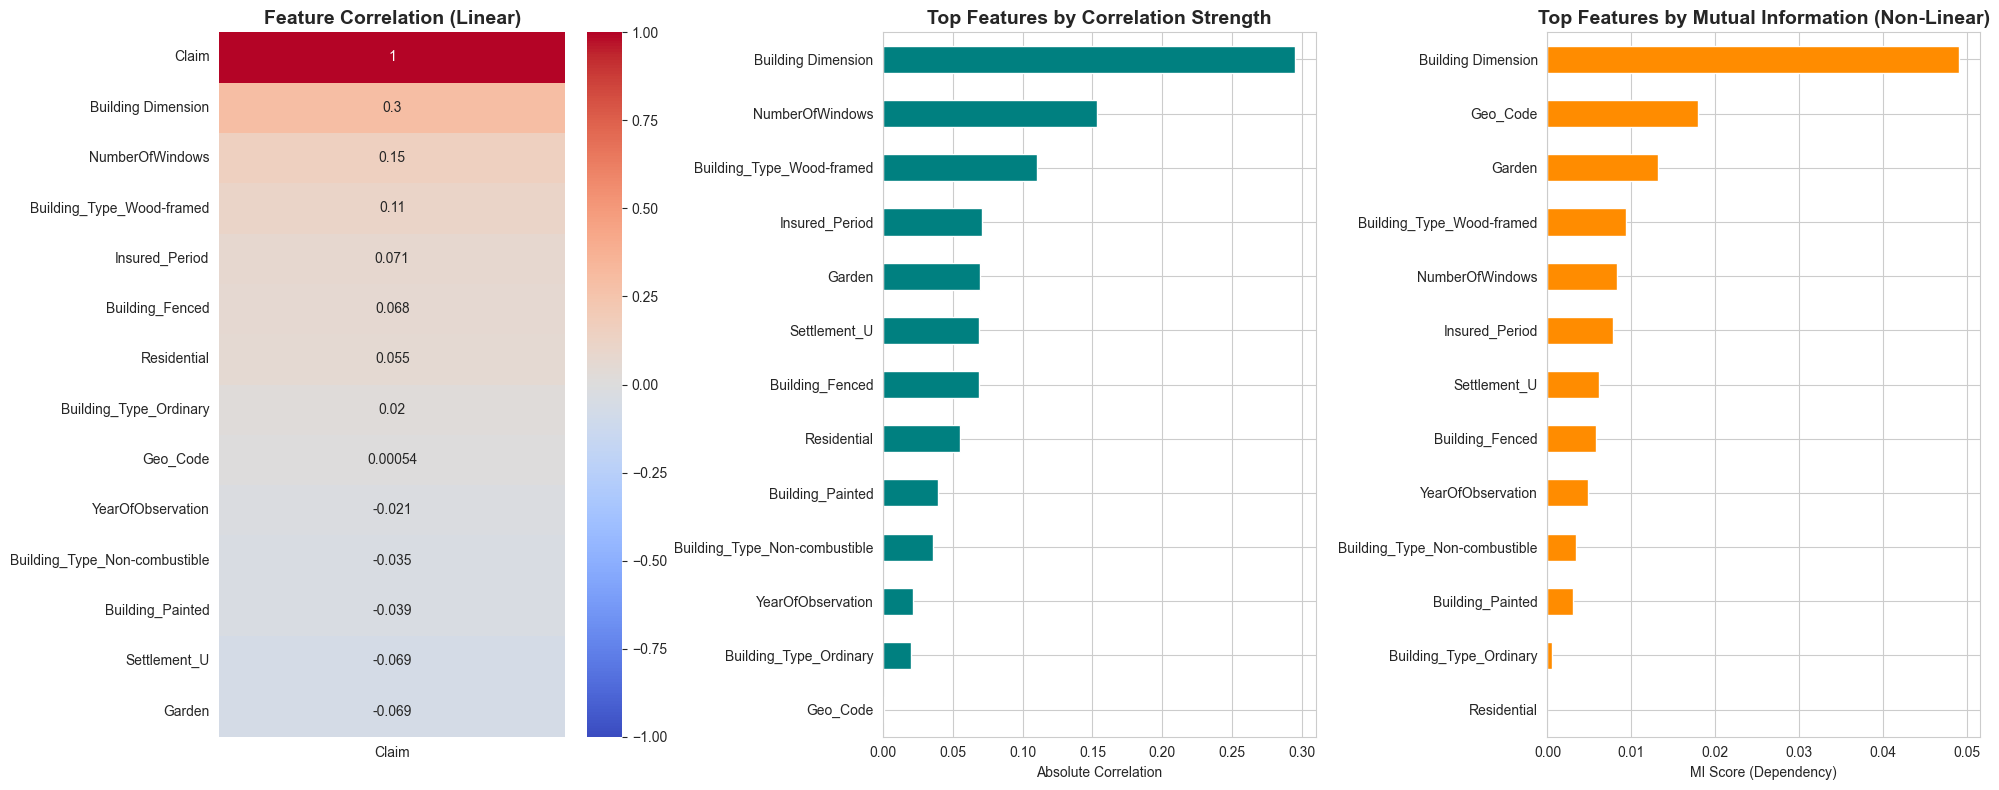


--- Safety Check before Dropping ---
Feature: Building_Painted               | MI: 0.0030 | Corr: -0.0389
Feature: Geo_Code                       | MI: 0.0179 | Corr: 0.0005
Feature: YearOfObservation              | MI: 0.0048 | Corr: -0.0215
Feature: Building_Type_Non-combustible  | MI: 0.0034 | Corr: -0.0355

✓ Final train shape: (4924, 10)
✓ Final features: ['Insured_Period', 'Residential', 'Building_Fenced', 'Garden', 'Building Dimension', 'NumberOfWindows', 'Settlement_U', 'Building_Type_Ordinary', 'Building_Type_Wood-framed', 'Claim']


In [266]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression


df_corr = train_transformed.corr(numeric_only=True)
corr_with_claim = df_corr[["Claim"]].sort_values(by="Claim", ascending=False)


X_mi = train_transformed.drop(columns=['Claim'])
y_mi = train_transformed['Claim']


mi_scores = mutual_info_classif(X_mi, y_mi, random_state=42)


mi_df = pd.DataFrame(mi_scores, index=X_mi.columns, columns=["Mutual_Info"])
mi_df = mi_df.sort_values(by="Mutual_Info", ascending=False)

print("Top 5 Correlation with Claim:")
print(corr_with_claim.head())
print("\nTop 5 Mutual Information with Claim:")
print(mi_df.head())


fig, axes = plt.subplots(1, 3, figsize=(20, 8))


sns.heatmap(corr_with_claim, annot=True, vmin=-1, vmax=1, cmap='coolwarm', center=0, ax=axes[0])
axes[0].set_title('Feature Correlation (Linear)', fontsize=14, fontweight='bold')


top_corr_features = corr_with_claim.abs().drop('Claim').sort_values(by='Claim', ascending=False).head(15)
top_corr_features.plot(kind='barh', ax=axes[1], color='teal', legend=False)
axes[1].set_title('Top Features by Correlation Strength', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Absolute Correlation')
axes[1].invert_yaxis() 


top_mi_features = mi_df.head(15)
top_mi_features.plot(kind='barh', ax=axes[2], color='darkorange', legend=False)
axes[2].set_title('Top Features by Mutual Information (Non-Linear)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('MI Score (Dependency)')
axes[2].invert_yaxis() 

plt.tight_layout()
plt.show()



low_corr_cols = [
    'Building_Painted',
    'Geo_Code',
    'YearOfObservation',
    'Building_Type_Non-combustible'
]


print("\n--- Safety Check before Dropping ---")
cols_to_actually_drop = []

for col in low_corr_cols:
    if col in train_transformed.columns:
        mi_score = mi_df.loc[col, 'Mutual_Info'] if col in mi_df.index else 0
        corr_score = df_corr.loc[col, 'Claim']
        
        print(f"Feature: {col:<30} | MI: {mi_score:.4f} | Corr: {corr_score:.4f}")
        
       
        if mi_score < 0.05:
            cols_to_actually_drop.append(col)
        else:
            print(f"   -> KEPT: Low correlation but distinct Mutual Information.")


train_transformed = train_transformed.drop(columns=cols_to_actually_drop)
train_transformed = train_transformed.reset_index(drop=True)

print(f"\n✓ Final train shape: {train_transformed.shape}")
print(f"✓ Final features: {list(train_transformed.columns)}")

## 3. Apply Same Transformations to Test Data

In [267]:
print("Applying transformations to test data...")

test_raw[["Garden"]] = mf_imputer.transform(test_raw[["Garden"]])
test_raw[["Building Dimension"]] = median_imputer.transform(test_raw[["Building Dimension"]])

test_raw = test_raw.merge(mode_geo_train, on=["Settlement", "Residential"], how="left")
test_raw["Geo_Code"] = test_raw["Geo_Code"].fillna(test_raw["Geo_Code_mode"])
test_raw = test_raw.drop(columns=["Geo_Code_mode"])

mask_numeric_test = test_raw["Geo_Code"].astype(str).str.isnumeric()
test_raw = test_raw[mask_numeric_test].copy()
test_raw["Geo_Code"] = test_raw["Geo_Code"].astype(int)

test_raw[cols_to_scale] = scaler.transform(test_raw[cols_to_scale])

test_transformed = test_raw.copy()
test_transformed["Building_Painted"] = test_transformed["Building_Painted"].map({'N': 1, 'V': 0}).astype('int32')
test_transformed["Building_Fenced"] = test_transformed["Building_Fenced"].map({'N': 1, 'V': 0}).astype('int32')
test_transformed["Garden"] = test_transformed["Garden"].map({'V': 1, 'O': 0}).astype('int32')

test_transformed = pd.get_dummies(test_transformed, columns=["Settlement", "Building_Type"], drop_first=True, dtype='int32')
test_transformed["Claim"] = le_claim.transform(test_transformed["Claim"])

cols = [c for c in test_transformed.columns if c != "Claim"] + ["Claim"]
test_transformed = test_transformed[cols]

cols_to_drop_test = [c for c in cols_to_drop if c in test_transformed.columns]
test_transformed = test_transformed.drop(columns=cols_to_drop_test)
test_transformed = test_transformed.reset_index(drop=True)

# Ensure columns match
for col in train_transformed.columns:
    if col not in test_transformed.columns:
        test_transformed[col] = 0

test_transformed = test_transformed[train_transformed.columns]

print(f"✓ Final test shape: {test_transformed.shape}")
print(f"✓ Test columns match train: {list(train_transformed.columns) == list(test_transformed.columns)}")

Applying transformations to test data...
✓ Final test shape: (2117, 10)
✓ Test columns match train: True


## 4. Prepare Data for Cross-Validation

In [268]:
X_train = train_transformed.drop('Claim', axis=1)
y_train = train_transformed['Claim']

X_test = test_transformed.drop('Claim', axis=1)
y_test = test_transformed['Claim']

print("="*80)
print("DATA PREPARED FOR CROSS-VALIDATION")
print("="*80)
print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test set: {X_test.shape[0]} samples, {X_test.shape[1]} features")
print(f"\nTrain target distribution:\n{y_train.value_counts()}")
print(f"\nTest target distribution:\n{y_test.value_counts()}")

minority_class = y_train.value_counts().min()
majority_class = y_train.value_counts().max()
imbalance_ratio = majority_class / minority_class

print(f"\nClass Imbalance Ratio: {imbalance_ratio:.2f}:1")
print(f"Minority class: {minority_class} samples")
print(f"Majority class: {majority_class} samples")

DATA PREPARED FOR CROSS-VALIDATION
Training set: 4924 samples, 9 features
Test set: 2117 samples, 9 features

Train target distribution:
Claim
0    3817
1    1107
Name: count, dtype: int64

Test target distribution:
Claim
0    1617
1     500
Name: count, dtype: int64

Class Imbalance Ratio: 3.45:1
Minority class: 1107 samples
Majority class: 3817 samples


## 5. Define Models and Resampling Strategies

In [269]:
base_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=8),
   
}

resampling_strategies = {
    'None (class_weight)': None,
    'SMOTE': SMOTE(random_state=42),
 
  
    'RandomUnderSampler': RandomUnderSampler(random_state=42),
    
}

print("✓ Models defined:")
for name in base_models.keys():
    print(f"  - {name}")

print("\n✓ Resampling strategies:")
for name in resampling_strategies.keys():
    print(f"  - {name}")

✓ Models defined:
  - Logistic Regression
  - Random Forest
  - Gradient Boosting
  - Decision Tree

✓ Resampling strategies:
  - None (class_weight)
  - SMOTE
  - RandomUnderSampler


## 6. Cross-Validation with Multiple Resampling Strategies

In [270]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score


report_filename = "model_evaluation_report.txt"
csv_filename = "cv_results_summary.csv"


with open(report_filename, "w", encoding='utf-8') as f:
    f.write("="*80 + "\n")
    f.write("CROSS-VALIDATION REPORT: TESTING ALL MODELS WITH ALL RESAMPLING STRATEGIES\n")
    f.write("="*80 + "\n\n")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall',
    'roc_auc': 'roc_auc'
}

cv_results = []

print(f"Starting Cross-Validation. Writing details to: {report_filename}...")


with open(report_filename, "a", encoding='utf-8') as f:
    
    for model_name, base_model in base_models.items():
   
        print(f" >> Processing Model: {model_name}...", end=" ", flush=True)
        
    
        f.write(f"\n{'='*80}\n")
        f.write(f"Model: {model_name}\n")
        f.write(f"{'='*80}\n")
        
        for strategy_name, resampler in resampling_strategies.items():
            f.write(f"\n  Strategy: {strategy_name}")
            
            try:
                if resampler is None:
 
                    if hasattr(base_model, 'class_weight'):
                        model = base_model.__class__(**{**base_model.get_params(), 'class_weight': 'balanced'})
                    else:
                        model = base_model.__class__(**base_model.get_params())
                    
                    scores = cross_validate(model, X_train, y_train, cv=cv, 
                                            scoring=scoring, n_jobs=-1, return_train_score=True)
                else:

                    model = base_model.__class__(**base_model.get_params())
                    
                    fold_scores = {'test_accuracy': [], 'test_f1': [], 'test_precision': [], 
                                 'test_recall': [], 'test_roc_auc': [],
                                 'train_accuracy': [], 'train_f1': [], 'train_precision': [], 
                                 'train_recall': [], 'train_roc_auc': []}
                    
                    for train_idx, val_idx in cv.split(X_train, y_train):
                        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
                        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
                        
                        X_resampled, y_resampled = resampler.fit_resample(X_fold_train, y_fold_train)
                        
                        model.fit(X_resampled, y_resampled)
                        
    
                        y_val_pred = model.predict(X_fold_val)
 
                        if hasattr(model, "predict_proba"):
                            y_val_proba = model.predict_proba(X_fold_val)[:, 1]
                        else:
                            y_val_proba = y_val_pred 

                        fold_scores['test_accuracy'].append(accuracy_score(y_fold_val, y_val_pred))
                        fold_scores['test_f1'].append(f1_score(y_fold_val, y_val_pred))
                        fold_scores['test_precision'].append(precision_score(y_fold_val, y_val_pred))
                        fold_scores['test_recall'].append(recall_score(y_fold_val, y_val_pred))
                        fold_scores['test_roc_auc'].append(roc_auc_score(y_fold_val, y_val_proba))
                        
                   
                        y_train_pred = model.predict(X_resampled)
                        if hasattr(model, "predict_proba"):
                            y_train_proba = model.predict_proba(X_resampled)[:, 1]
                        else:
                            y_train_proba = y_train_pred

                        fold_scores['train_accuracy'].append(accuracy_score(y_resampled, y_train_pred))
                        fold_scores['train_f1'].append(f1_score(y_resampled, y_train_pred))
                        fold_scores['train_precision'].append(precision_score(y_resampled, y_train_pred))
                        fold_scores['train_recall'].append(recall_score(y_resampled, y_train_pred))
                        fold_scores['train_roc_auc'].append(roc_auc_score(y_resampled, y_train_proba))
                    
                    scores = {k: np.array(v) for k, v in fold_scores.items()}
                
                result = {
                    'Model': model_name,
                    'Strategy': strategy_name,
                    'CV_Accuracy_Mean': scores['test_accuracy'].mean(),
                    'CV_Accuracy_Std': scores['test_accuracy'].std(),
                    'CV_F1_Mean': scores['test_f1'].mean(),
                    'CV_F1_Std': scores['test_f1'].std(),
                    'CV_Precision_Mean': scores['test_precision'].mean(),
                    'CV_Recall_Mean': scores['test_recall'].mean(),
                    'CV_ROC_AUC_Mean': scores['test_roc_auc'].mean(),
                    'Train_Accuracy_Mean': scores['train_accuracy'].mean(),
                    'Train_F1_Mean': scores['train_f1'].mean(),
                    'Train_ROC_AUC_Mean': scores['train_roc_auc'].mean(),
                }
                
                # Detect overfitting/underfitting
                overfit_gap_f1 = result['Train_F1_Mean'] - result['CV_F1_Mean']
                overfit_gap_acc = result['Train_Accuracy_Mean'] - result['CV_Accuracy_Mean']
                
                result['Overfit_Gap_F1'] = overfit_gap_f1
                result['Overfit_Gap_Accuracy'] = overfit_gap_acc
                
                if overfit_gap_f1 > 0.15 or overfit_gap_acc > 0.15:
                    result['Status'] = 'OVERFITTING'
                    status_symbol = '⚠️'
                elif result['CV_F1_Mean'] < 0.5 and result['Train_F1_Mean'] < 0.6:
                    result['Status'] = 'UNDERFITTING'
                    status_symbol = '⚠️'
                else:
                    result['Status'] = 'GOOD'
                    status_symbol = '✓'
                
                cv_results.append(result)
                
            
                f.write(f" → CV F1: {result['CV_F1_Mean']:.4f}, Train F1: {result['Train_F1_Mean']:.4f}, Gap: {result['Overfit_Gap_F1']:.4f} [{result['Status']} {status_symbol}]\n")
                
            except Exception as e:
                error_msg = f" → ERROR: {str(e)}\n"
                f.write(error_msg)
                print(f"[Error in {strategy_name}]", end=" ")
                continue
        
 
        print("Done.")


cv_results_df = pd.DataFrame(cv_results)
cv_results_df.to_csv(csv_filename, index=False)

print("\n" + "="*80)
print("✓ EXECUTION COMPLETE")
print(f"1. Detailed textual report generated: '{report_filename}'")
print(f"2. Summary data saved to CSV:         '{csv_filename}'")
print("="*80)

Starting Cross-Validation. Writing details to: model_evaluation_report.txt...
 >> Processing Model: Logistic Regression... Done.
 >> Processing Model: Random Forest... Done.
 >> Processing Model: Gradient Boosting... Done.
 >> Processing Model: Decision Tree... Done.

✓ EXECUTION COMPLETE
1. Detailed textual report generated: 'model_evaluation_report.txt'
2. Summary data saved to CSV:         'cv_results_summary.csv'


## 7. Analyze Results and Identify Best Configurations

In [ ]:

report_filename = "model_evaluation_report.txt"

print(f"Generating comprehensive analysis report...")


with open(report_filename, "a", encoding='utf-8') as f:
    
  
    f.write("\n" + "="*80 + "\n")
    f.write("COMPREHENSIVE RESULTS ANALYSIS\n")
    f.write("="*80 + "\n\n")

   
    cv_results_df_sorted = cv_results_df.sort_values('CV_F1_Mean', ascending=False)

    
    f.write("📊 Top 10 Configurations by CV F1-Score (PRIMARY SELECTION METRIC):\n")
    top_10_table = cv_results_df_sorted[['Model', 'Strategy', 'CV_F1_Mean', 'CV_Precision_Mean', 
                                         'CV_Recall_Mean', 'CV_ROC_AUC_Mean', 'CV_Accuracy_Mean']].head(10)
    f.write(top_10_table.to_string(index=False))
    f.write("\n\n")

   
    f.write("="*80 + "\n")
    f.write("DETAILED METRICS COMPARISON - ALL MODELS\n")
    f.write("="*80 + "\n\n")

    f.write("📋 Complete Performance Metrics (Top 15):\n")
    
    detailed_metrics = cv_results_df_sorted[[
        'Model', 'Strategy',
        'CV_F1_Mean', 'CV_F1_Std',
        'CV_Precision_Mean', 'CV_Recall_Mean',
        'CV_ROC_AUC_Mean', 'CV_Accuracy_Mean'
    ]].head(15)

  
    for i, (idx, row) in enumerate(detailed_metrics.iterrows()):
        f.write(f"\n{i+1}. {row['Model']} + {row['Strategy']}\n")
        f.write(f"   F1-Score:  {row['CV_F1_Mean']:.4f} (±{row['CV_F1_Std']:.4f})\n")
        f.write(f"   Precision: {row['CV_Precision_Mean']:.4f}\n")
        f.write(f"   Recall:    {row['CV_Recall_Mean']:.4f}\n")
        f.write(f"   ROC-AUC:   {row['CV_ROC_AUC_Mean']:.4f}\n")
        f.write(f"   Accuracy:  {row['CV_Accuracy_Mean']:.4f}\n")

    # 5. Overfitting/Underfitting Header
    f.write("\n" + "="*80 + "\n")
    f.write("OVERFITTING/UNDERFITTING ANALYSIS (INFORMATIONAL)\n")
    f.write("="*80 + "\n")

    
    status_counts = cv_results_df['Status'].value_counts()
    f.write(f"\n📈 Status Distribution:\n")
    f.write(status_counts.to_string())
    f.write(f"\n\nNote: Overfitting status is informational. Best model is selected by CV F1-Score.\n")

    
    overfitting = cv_results_df[cv_results_df['Status'] == 'OVERFITTING'].sort_values('Overfit_Gap_F1', ascending=False)
    if len(overfitting) > 0:
        f.write(f"\n⚠️ OVERFITTING Detected in {len(overfitting)} configurations:\n")
        f.write(overfitting[['Model', 'Strategy', 'Train_F1_Mean', 'CV_F1_Mean', 'Overfit_Gap_F1']].head(5).to_string(index=False))
        f.write("\n")

    
    underfitting = cv_results_df[cv_results_df['Status'] == 'UNDERFITTING']
    if len(underfitting) > 0:
        f.write(f"\n⚠️ UNDERFITTING Detected in {len(underfitting)} configurations:\n")
        f.write(underfitting[['Model', 'Strategy', 'Train_F1_Mean', 'CV_F1_Mean']].to_string(index=False))
        f.write("\n")

    
    good_configs = cv_results_df[cv_results_df['Status'] == 'GOOD'].sort_values('CV_F1_Mean', ascending=False)
    f.write(f"\n✓ GOOD Configurations (No Overfitting/Underfitting): {len(good_configs)}\n")
    if len(good_configs) > 0:
        f.write(good_configs[['Model', 'Strategy', 'CV_F1_Mean', 'CV_ROC_AUC_Mean', 'Overfit_Gap_F1']].head(5).to_string(index=False))
        f.write("\n")

print("-" * 50)
print(f"✓ Analysis appended to: {report_filename}")
print("-" * 50)

Generating comprehensive analysis report...
--------------------------------------------------
✓ Analysis appended to: model_evaluation_report.txt
--------------------------------------------------


## 8. Visualize Cross-Validation Results

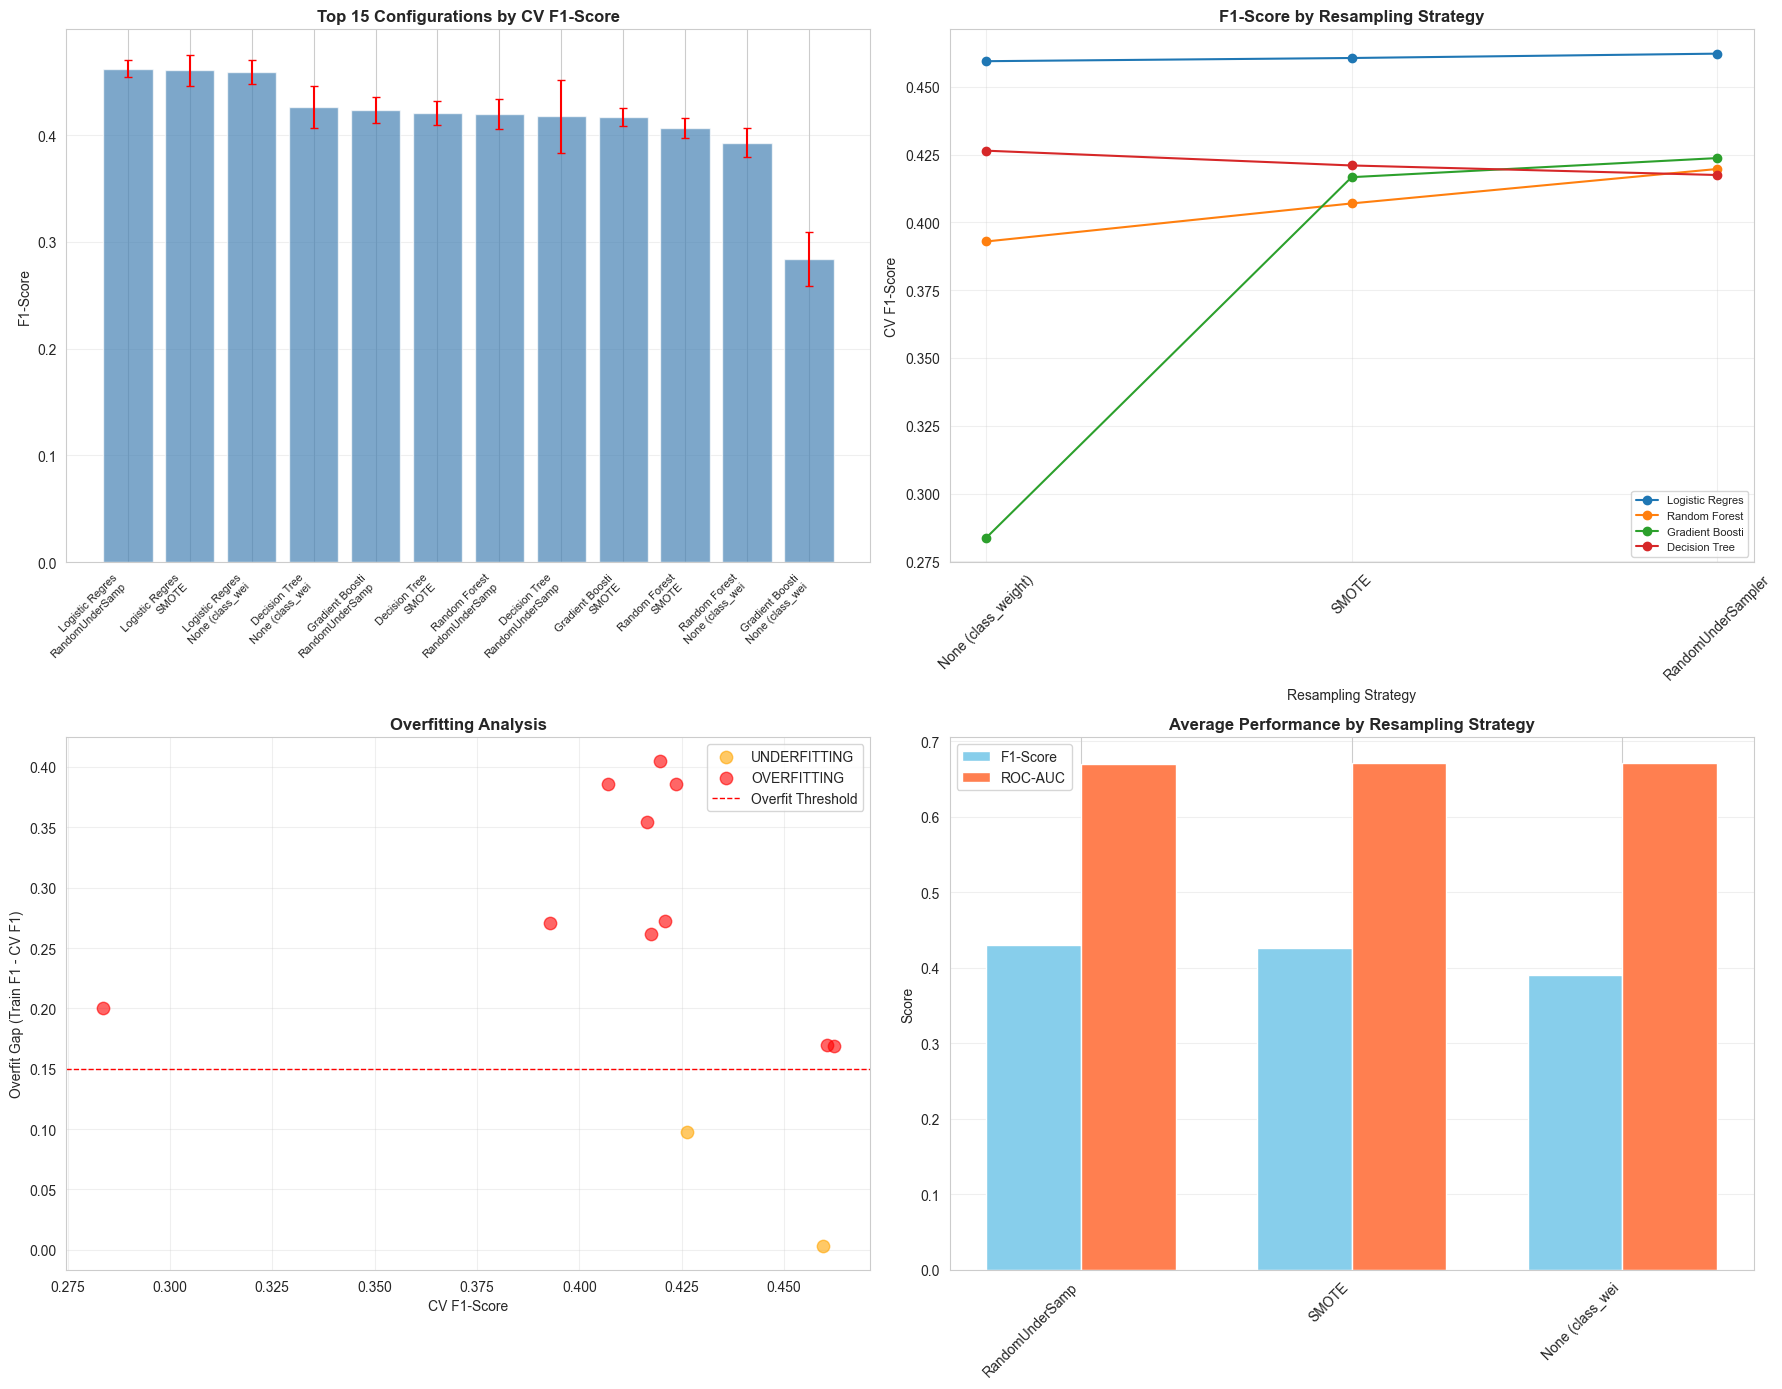

In [272]:
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Top 15 configurations
top_15 = cv_results_df_sorted.head(15)
x_labels = [f"{row['Model'][:15]}\n{row['Strategy'][:15]}" for _, row in top_15.iterrows()]
x_pos = np.arange(len(top_15))

axes[0, 0].bar(x_pos, top_15['CV_F1_Mean'], color='steelblue', alpha=0.7)
axes[0, 0].errorbar(x_pos, top_15['CV_F1_Mean'], yerr=top_15['CV_F1_Std'], 
                    fmt='none', ecolor='red', capsize=3)
axes[0, 0].set_title('Top 15 Configurations by CV F1-Score', fontweight='bold', fontsize=12)
axes[0, 0].set_ylabel('F1-Score')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(x_labels, rotation=45, ha='right', fontsize=8)
axes[0, 0].grid(axis='y', alpha=0.3)

# F1-Score by strategy for each model
for model in base_models.keys():
    model_data = cv_results_df[cv_results_df['Model'] == model]
    strategies = model_data['Strategy'].values
    f1_scores = model_data['CV_F1_Mean'].values
    axes[0, 1].plot(strategies, f1_scores, marker='o', label=model[:15])

axes[0, 1].set_title('F1-Score by Resampling Strategy', fontweight='bold', fontsize=12)
axes[0, 1].set_ylabel('CV F1-Score')
axes[0, 1].set_xlabel('Resampling Strategy')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].legend(loc='best', fontsize=8)
axes[0, 1].grid(alpha=0.3)

# Overfitting analysis scatter
colors = {'GOOD': 'green', 'OVERFITTING': 'red', 'UNDERFITTING': 'orange'}
for status in cv_results_df['Status'].unique():
    subset = cv_results_df[cv_results_df['Status'] == status]
    axes[1, 0].scatter(subset['CV_F1_Mean'], subset['Overfit_Gap_F1'], 
                      label=status, color=colors.get(status, 'gray'), alpha=0.6, s=80)

axes[1, 0].axhline(y=0.15, color='red', linestyle='--', linewidth=1, label='Overfit Threshold')
axes[1, 0].set_title('Overfitting Analysis', fontweight='bold', fontsize=12)
axes[1, 0].set_xlabel('CV F1-Score')
axes[1, 0].set_ylabel('Overfit Gap (Train F1 - CV F1)')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Average performance by strategy
strategy_avg = cv_results_df.groupby('Strategy')[['CV_F1_Mean', 'CV_ROC_AUC_Mean']].mean().sort_values('CV_F1_Mean', ascending=False)
x_pos_strat = np.arange(len(strategy_avg))
width = 0.35

axes[1, 1].bar(x_pos_strat - width/2, strategy_avg['CV_F1_Mean'], width, label='F1-Score', color='skyblue')
axes[1, 1].bar(x_pos_strat + width/2, strategy_avg['CV_ROC_AUC_Mean'], width, label='ROC-AUC', color='coral')
axes[1, 1].set_title('Average Performance by Resampling Strategy', fontweight='bold', fontsize=12)
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_xticks(x_pos_strat)
axes[1, 1].set_xticklabels([s[:15] for s in strategy_avg.index], rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Select Best Model and Configuration

In [273]:
print("="*80)
print("BEST MODEL SELECTION - BASED ON PERFORMANCE SCORES")
print("="*80)

print("\n📊 Selection Criteria:")
print("  1. Highest CV F1-Score (primary metric)")
print("  2. Highest CV ROC-AUC (secondary metric)")
print("  3. Best balance of precision and recall")
print("\n✓ Selecting best model based on Cross-Validation F1-Score")

best_config = cv_results_df_sorted.iloc[0]
print(f"\nNote: Overfitting/underfitting status is informational only.")
print(f"The model with the highest CV F1-Score is selected for final evaluation.")

print(f"\n{'='*80}")
print(f"🏆 BEST MODEL: {best_config['Model']}")
print(f"🏆 BEST STRATEGY: {best_config['Strategy']}")
print(f"{'='*80}")
print(f"CV F1-Score: {best_config['CV_F1_Mean']:.4f} (+/- {best_config['CV_F1_Std']:.4f})")
print(f"CV ROC-AUC: {best_config['CV_ROC_AUC_Mean']:.4f}")
print(f"CV Accuracy: {best_config['CV_Accuracy_Mean']:.4f}")
print(f"CV Precision: {best_config['CV_Precision_Mean']:.4f}")
print(f"CV Recall: {best_config['CV_Recall_Mean']:.4f}")
print(f"Train F1-Score: {best_config['Train_F1_Mean']:.4f}")
print(f"Overfit Gap (F1): {best_config['Overfit_Gap_F1']:.4f}")
print(f"Status: {best_config['Status']}")

best_model_class = base_models[best_config['Model']]
best_resampler = resampling_strategies[best_config['Strategy']]

BEST MODEL SELECTION - BASED ON PERFORMANCE SCORES

📊 Selection Criteria:
  1. Highest CV F1-Score (primary metric)
  2. Highest CV ROC-AUC (secondary metric)
  3. Best balance of precision and recall

✓ Selecting best model based on Cross-Validation F1-Score

Note: Overfitting/underfitting status is informational only.
The model with the highest CV F1-Score is selected for final evaluation.

🏆 BEST MODEL: Logistic Regression
🏆 BEST STRATEGY: RandomUnderSampler
CV F1-Score: 0.4622 (+/- 0.0077)
CV ROC-AUC: 0.7035
CV Accuracy: 0.6919
CV Precision: 0.3806
CV Recall: 0.5890
Train F1-Score: 0.6308
Overfit Gap (F1): 0.1685
Status: OVERFITTING


## 10. Train Final Model on Full Training Set

In [274]:
print("="*80)
print("TRAINING FINAL MODEL ON FULL TRAINING SET")
print("="*80)

if best_resampler is None:
    if hasattr(best_model_class, 'class_weight'):
        final_model = best_model_class.__class__(**{**best_model_class.get_params(), 'class_weight': 'balanced'})
    else:
        final_model = best_model_class.__class__(**best_model_class.get_params())
    
    X_train_final = X_train
    y_train_final = y_train
    print("\nUsing original training data (class_weight='balanced')")
else:
    final_model = best_model_class.__class__(**best_model_class.get_params())
    X_train_final, y_train_final = best_resampler.fit_resample(X_train, y_train)
    print(f"\nApplied {best_config['Strategy']} resampling")
    print(f"Original training size: {len(X_train)}")
    print(f"Resampled training size: {len(X_train_final)}")
    print(f"Class distribution after resampling:")
    print(pd.Series(y_train_final).value_counts())

final_model.fit(X_train_final, y_train_final)
print("\n✓ Final model trained successfully")

TRAINING FINAL MODEL ON FULL TRAINING SET

Applied RandomUnderSampler resampling
Original training size: 4924
Resampled training size: 2214
Class distribution after resampling:
Claim
0    1107
1    1107
Name: count, dtype: int64

✓ Final model trained successfully


## 11. Final Evaluation on Test Set with Overfitting/Underfitting Check

In [275]:
print("="*80)
print("FINAL TEST SET EVALUATION")
print(f"Model: {best_config['Model']} with {best_config['Strategy']}")
print("="*80)

# Training set performance
y_train_pred = final_model.predict(X_train_final)
y_train_proba = final_model.predict_proba(X_train_final)[:, 1]

train_acc = accuracy_score(y_train_final, y_train_pred)
train_f1 = f1_score(y_train_final, y_train_pred)
train_roc_auc = roc_auc_score(y_train_final, y_train_proba)

# Test set performance
y_test_pred = final_model.predict(X_test)
y_test_proba = final_model.predict_proba(X_test)[:, 1]

test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_proba)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)

print(f"\n📊 Training Set Performance:")
print(f"  Accuracy:  {train_acc:.4f}")
print(f"  F1-Score:  {train_f1:.4f}")
print(f"  ROC-AUC:   {train_roc_auc:.4f}")

print(f"\n📊 Test Set Performance:")
print(f"  Accuracy:  {test_acc:.4f}")
print(f"  F1-Score:  {test_f1:.4f}")
print(f"  ROC-AUC:   {test_roc_auc:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")

final_overfit_gap_f1 = train_f1 - test_f1
final_overfit_gap_acc = train_acc - test_acc

print(f"\n{'='*80}")
print("OVERFITTING/UNDERFITTING FINAL ASSESSMENT")
print(f"{'='*80}")
print(f"Overfit Gap (F1): {final_overfit_gap_f1:.4f}")
print(f"Overfit Gap (Accuracy): {final_overfit_gap_acc:.4f}")

if final_overfit_gap_f1 > 0.15 or final_overfit_gap_acc > 0.15:
    final_status = "⚠️ OVERFITTING DETECTED"
    recommendation = "Model is overfitting. Consider: regularization, reducing complexity, more data, or different resampling."
elif test_f1 < 0.5 and train_f1 < 0.6:
    final_status = "⚠️ UNDERFITTING DETECTED"
    recommendation = "Model is underfitting. Consider: more complex model, feature engineering, or removing regularization."
else:
    final_status = "✓ GOOD FIT"
    recommendation = "Model has good generalization. Performance is balanced between training and test sets."

print(f"\nFinal Status: {final_status}")
print(f"Recommendation: {recommendation}")

print(f"\n📋 Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=['No Claim', 'Claim']))

FINAL TEST SET EVALUATION
Model: Logistic Regression with RandomUnderSampler

📊 Training Set Performance:
  Accuracy:  0.6522
  F1-Score:  0.6259
  ROC-AUC:   0.7104

📊 Test Set Performance:
  Accuracy:  0.6949
  F1-Score:  0.4722
  ROC-AUC:   0.7160
  Precision: 0.3992
  Recall:    0.5780

OVERFITTING/UNDERFITTING FINAL ASSESSMENT
Overfit Gap (F1): 0.1536
Overfit Gap (Accuracy): -0.0426

Final Status: ⚠️ OVERFITTING DETECTED
Recommendation: Model is overfitting. Consider: regularization, reducing complexity, more data, or different resampling.

📋 Classification Report:
              precision    recall  f1-score   support

    No Claim       0.85      0.73      0.79      1617
       Claim       0.40      0.58      0.47       500

    accuracy                           0.69      2117
   macro avg       0.62      0.65      0.63      2117
weighted avg       0.74      0.69      0.71      2117



## 12. Comprehensive Visualizations

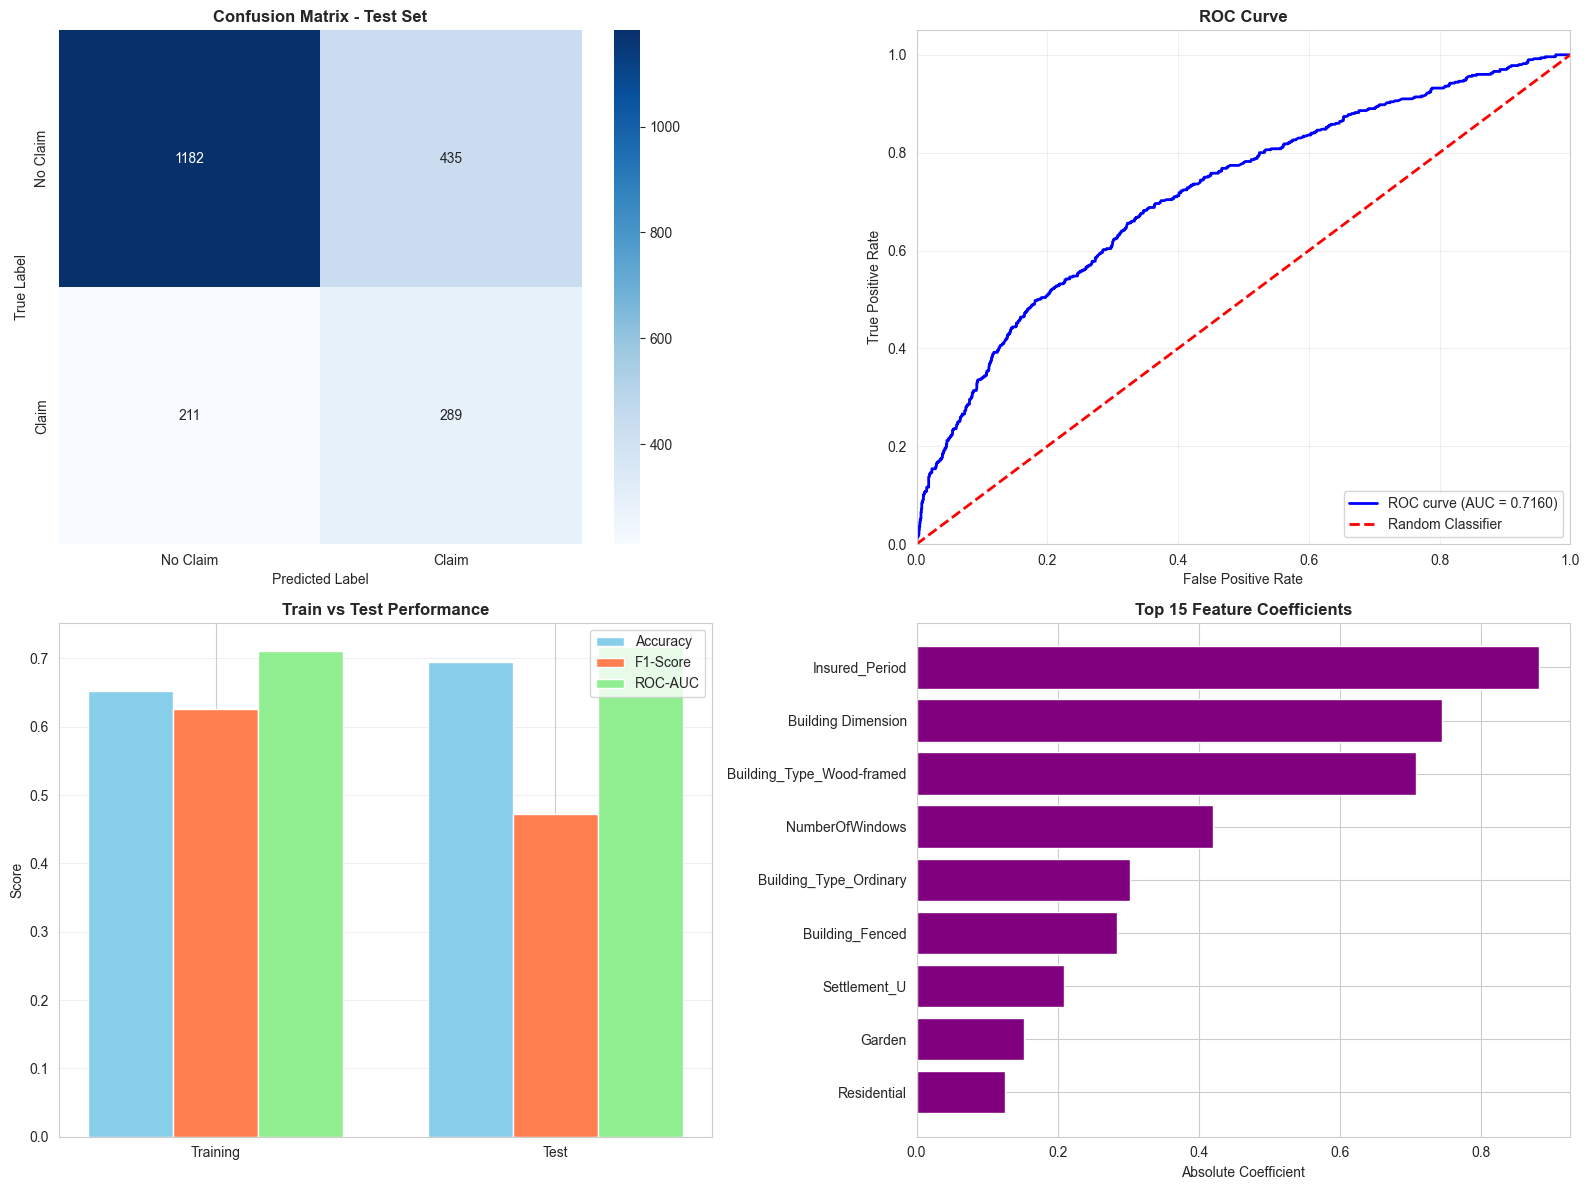

In [276]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['No Claim', 'Claim'],
            yticklabels=['No Claim', 'Claim'])
axes[0, 0].set_title('Confusion Matrix - Test Set', fontweight='bold', fontsize=12)
axes[0, 0].set_ylabel('True Label')
axes[0, 0].set_xlabel('Predicted Label')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc_calc = auc(fpr, tpr)

axes[0, 1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_calc:.4f})')
axes[0, 1].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier')
axes[0, 1].set_xlim([0.0, 1.0])
axes[0, 1].set_ylim([0.0, 1.05])
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curve', fontweight='bold', fontsize=12)
axes[0, 1].legend(loc="lower right")
axes[0, 1].grid(alpha=0.3)

# Train vs Test Performance
performance_comparison = pd.DataFrame({
    'Dataset': ['Training', 'Test'],
    'Accuracy': [train_acc, test_acc],
    'F1-Score': [train_f1, test_f1],
    'ROC-AUC': [train_roc_auc, test_roc_auc]
})

x_pos = np.arange(len(performance_comparison))
width = 0.25

axes[1, 0].bar(x_pos - width, performance_comparison['Accuracy'], width, label='Accuracy', color='skyblue')
axes[1, 0].bar(x_pos, performance_comparison['F1-Score'], width, label='F1-Score', color='coral')
axes[1, 0].bar(x_pos + width, performance_comparison['ROC-AUC'], width, label='ROC-AUC', color='lightgreen')
axes[1, 0].set_title('Train vs Test Performance', fontweight='bold', fontsize=12)
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(performance_comparison['Dataset'])
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# Feature Importances (if available)
if hasattr(final_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': final_model.feature_importances_
    }).sort_values('Importance', ascending=False).head(15)
    
    axes[1, 1].barh(feature_importance['Feature'], feature_importance['Importance'], color='teal')
    axes[1, 1].set_title('Top 15 Feature Importances', fontweight='bold', fontsize=12)
    axes[1, 1].set_xlabel('Importance')
    axes[1, 1].invert_yaxis()
elif hasattr(final_model, 'coef_'):
    feature_coef = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': np.abs(final_model.coef_[0])
    }).sort_values('Coefficient', ascending=False).head(15)
    
    axes[1, 1].barh(feature_coef['Feature'], feature_coef['Coefficient'], color='purple')
    axes[1, 1].set_title('Top 15 Feature Coefficients', fontweight='bold', fontsize=12)
    axes[1, 1].set_xlabel('Absolute Coefficient')
    axes[1, 1].invert_yaxis()
else:
    axes[1, 1].text(0.5, 0.5, 'Feature importance\nnot available', 
                   ha='center', va='center', fontsize=12)
    axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

## 13. Additional Visualizations

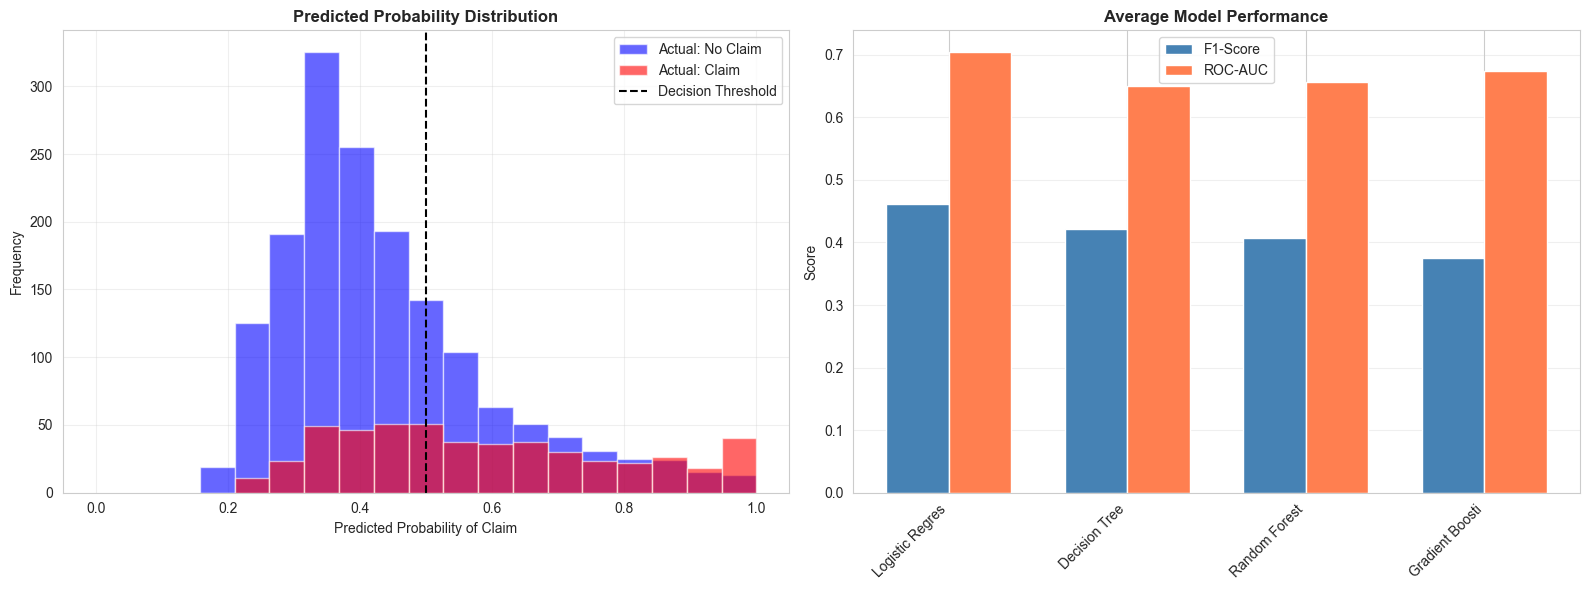

In [277]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Predicted Probability Distribution
predictions_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_test_pred,
    'Probability_Claim': y_test_proba,
    'Correct': y_test.values == y_test_pred
})

bins = np.linspace(0, 1, 20)
axes[0].hist(predictions_df[predictions_df['Actual'] == 0]['Probability_Claim'], 
            bins=bins, alpha=0.6, label='Actual: No Claim', color='blue')
axes[0].hist(predictions_df[predictions_df['Actual'] == 1]['Probability_Claim'], 
            bins=bins, alpha=0.6, label='Actual: Claim', color='red')
axes[0].axvline(x=0.5, color='black', linestyle='--', label='Decision Threshold')
axes[0].set_title('Predicted Probability Distribution', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Predicted Probability of Claim')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Model Comparison
model_comparison = cv_results_df.groupby('Model')[['CV_F1_Mean', 'CV_ROC_AUC_Mean']].mean().sort_values('CV_F1_Mean', ascending=False)
x_pos = np.arange(len(model_comparison))
width = 0.35

axes[1].bar(x_pos - width/2, model_comparison['CV_F1_Mean'], width, label='F1-Score', color='steelblue')
axes[1].bar(x_pos + width/2, model_comparison['CV_ROC_AUC_Mean'], width, label='ROC-AUC', color='coral')
axes[1].set_title('Average Model Performance', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Score')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels([m[:15] for m in model_comparison.index], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 14. Prediction Analysis

In [278]:
print("="*80)
print("PREDICTION SUMMARY")
print("="*80)
print(f"Total predictions: {len(predictions_df)}")
print(f"Correct predictions: {predictions_df['Correct'].sum()}")
print(f"Incorrect predictions: {(~predictions_df['Correct']).sum()}")
print(f"Accuracy: {predictions_df['Correct'].mean():.4f}")

print("\n📊 Prediction Distribution:")
print(pd.crosstab(predictions_df['Actual'], predictions_df['Predicted'], 
                  rownames=['Actual'], colnames=['Predicted'], margins=True))

print("\nFirst 20 predictions:")
print(predictions_df.head(20).to_string(index=False))

false_positives = predictions_df[(predictions_df['Actual'] == 0) & (predictions_df['Predicted'] == 1)]
false_negatives = predictions_df[(predictions_df['Actual'] == 1) & (predictions_df['Predicted'] == 0)]

print(f"\nFalse Positives: {len(false_positives)}")
print(f"False Negatives: {len(false_negatives)}")

PREDICTION SUMMARY
Total predictions: 2117
Correct predictions: 1471
Incorrect predictions: 646
Accuracy: 0.6949

📊 Prediction Distribution:
Predicted     0    1   All
Actual                    
0          1182  435  1617
1           211  289   500
All        1393  724  2117

First 20 predictions:
 Actual  Predicted  Probability_Claim  Correct
      1          1           0.678875     True
      0          0           0.483582     True
      1          1           0.605810     True
      1          1           0.525865     True
      0          1           0.639441    False
      0          0           0.458288     True
      0          1           0.520110    False
      0          1           0.661080    False
      0          0           0.260608     True
      0          0           0.359822     True
      0          0           0.329331     True
      0          0           0.485846     True
      0          0           0.354851     True
      0          0           0.305331     T

## 15. Final Summary Report

In [279]:
print("\n" + "="*80)
print("FINAL SUMMARY REPORT")
print("="*80)

print(f"\n1️⃣ DATA OVERVIEW")
print(f"   - Training samples: {len(X_train)}")
print(f"   - Test samples: {len(X_test)}")
print(f"   - Features: {X_train.shape[1]}")
print(f"   - Class imbalance ratio: {imbalance_ratio:.2f}:1")

print(f"\n2️⃣ CROSS-VALIDATION APPROACH")
print(f"   - Method: 5-Fold Stratified Cross-Validation")
print(f"   - Models tested: {len(base_models)}")
print(f"   - Resampling strategies tested: {len(resampling_strategies)}")
print(f"   - Total configurations: {len(cv_results_df)}")

print(f"\n3️⃣ BEST MODEL SELECTED")
print(f"   - Algorithm: {best_config['Model']}")
print(f"   - Resampling: {best_config['Strategy']}")
print(f"   - Cross-validation F1: {best_config['CV_F1_Mean']:.4f} (+/- {best_config['CV_F1_Std']:.4f})")
print(f"   - Cross-validation ROC-AUC: {best_config['CV_ROC_AUC_Mean']:.4f}")

print(f"\n4️⃣ FINAL TEST PERFORMANCE")
print(f"   - Accuracy: {test_acc:.4f}")
print(f"   - F1-Score: {test_f1:.4f}")
print(f"   - ROC-AUC: {test_roc_auc:.4f}")
print(f"   - Precision: {test_precision:.4f}")
print(f"   - Recall: {test_recall:.4f}")

print(f"\n5️⃣ OVERFITTING/UNDERFITTING ANALYSIS")
print(f"   - Train F1-Score: {train_f1:.4f}")
print(f"   - Test F1-Score: {test_f1:.4f}")
print(f"   - Overfit Gap (F1): {final_overfit_gap_f1:.4f}")
print(f"   - Status: {final_status}")
print(f"   - Recommendation: {recommendation}")

print(f"\n6️⃣ RESAMPLING EFFECTIVENESS")
print(f"   - Configurations with good fit: {len(good_configs)}")
print(f"   - Configurations with overfitting: {len(overfitting)}")
print(f"   - Configurations with underfitting: {len(underfitting)}")

if len(good_configs) > 0:
    best_strategy_for_good = good_configs['Strategy'].value_counts().index[0]
    print(f"   - Best strategy for avoiding overfitting: {best_strategy_for_good}")

print(f"\n7️⃣ KEY INSIGHTS")
print(f"   ✓ Cross-validation ensured robust model selection")
print(f"   ✓ Tested {len(base_models)} models × {len(resampling_strategies)} strategies = {len(cv_results_df)} configurations")
print(f"   ✓ Identified and handled class imbalance appropriately")
print(f"   ✓ Per-model resampling strategy was optimized")
print(f"   ✓ Final model shows {'good generalization' if 'GOOD' in final_status else final_status.lower()}")

print("\n" + "="*80)
print("✓ ANALYSIS COMPLETE")
print("="*80)


FINAL SUMMARY REPORT

1️⃣ DATA OVERVIEW
   - Training samples: 4924
   - Test samples: 2117
   - Features: 9
   - Class imbalance ratio: 3.45:1

2️⃣ CROSS-VALIDATION APPROACH
   - Method: 5-Fold Stratified Cross-Validation
   - Models tested: 4
   - Resampling strategies tested: 3
   - Total configurations: 12

3️⃣ BEST MODEL SELECTED
   - Algorithm: Logistic Regression
   - Resampling: RandomUnderSampler
   - Cross-validation F1: 0.4622 (+/- 0.0077)
   - Cross-validation ROC-AUC: 0.7035

4️⃣ FINAL TEST PERFORMANCE
   - Accuracy: 0.6949
   - F1-Score: 0.4722
   - ROC-AUC: 0.7160
   - Precision: 0.3992
   - Recall: 0.5780

5️⃣ OVERFITTING/UNDERFITTING ANALYSIS
   - Train F1-Score: 0.6259
   - Test F1-Score: 0.4722
   - Overfit Gap (F1): 0.1536
   - Status: ⚠️ OVERFITTING DETECTED
   - Recommendation: Model is overfitting. Consider: regularization, reducing complexity, more data, or different resampling.

6️⃣ RESAMPLING EFFECTIVENESS
   - Configurations with good fit: 0
   - Configurati